### SI 650 Homework 5

#### Import library

In [1]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

# your modules are imported here
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter, read_dataset
from ranker import Ranker, BM25, CrossEncoderScorer, PersonalizedBM25
from vector_ranker import VectorRanker
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker

from sentence_transformers import SentenceTransformer
from relevance import map_score, ndcg_score, run_relevance_tests
import torch

import matplotlib.pyplot as plt
import seaborn as sns

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Basic data setup**

In [2]:
# change these to point to actual file paths
STOPWORD_PATH = 'stopwords.txt'
DATASET_PATH = 'wikipedia_200k_dataset.jsonl.gz'
EDGELIST_PATH = 'edgelist.csv.gz'
NETWORK_STATS_PATH = 'network_stats.csv'
DOC_CATEGORY_INFO_PATH = 'doc_category_info.json'
RECOGNIZED_CATEGORY_PATH = 'recognized_categories.txt'
DOC2QUERY_PATH = 'doc2query.csv'
MAIN_INDEX = 'main_index_augmented'
TITLE_INDEX = 'title_index'
RELEVANCE_TRAIN_DATA = 'hw5_relevance.train.csv'
RELEVANCE_DEV_DATA = 'hw5_relevance.dev.csv'
RELEVANCE_TEST_DATA = 'hw5_relevance.test.csv'
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = 'wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
DOCUMENT_ID_TEXT = 'document-ids.txt'
PERSON_ATTRIBUTES = 'person-attributes.csv'

**Load Basic Statistics**

In [3]:
# Load in the stopwords
stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
print(f'Stopwords collected {len(stopwords)}')

# Load the document category info
doc_category_info = {}
with open(DOC_CATEGORY_INFO_PATH, 'r') as f:
    doc_category_info = json.load(f)
    doc_category_info = {int(k): v for k, v in doc_category_info.items()}

# Load the recognized categories
recognized_categories = set()
with open(RECOGNIZED_CATEGORY_PATH, 'r') as f:
    recognized_categories = set(map(lambda x: x.strip(), f.readlines()))
print(f'Recognized categories {len(recognized_categories)}')

# Load the network stats
network_feats = {}
networks_stats = pd.read_csv(NETWORK_STATS_PATH)
for row in tqdm(networks_stats.iterrows()):
    network_feats[row[1]['docid']] = row[1][1:].to_dict()
print(f'Network stats collection {len(network_feats)}')

Stopwords collected 543
Recognized categories 118


999841it [00:37, 26938.82it/s]

Network stats collection 999841


#### Problem 5

TOP 10 common labels for each person attribute

In [4]:
top_10_attributes = {}
person_attr_df = pd.read_csv(PERSON_ATTRIBUTES)
for attr in person_attr_df.columns[1:-1]:
    top_10_attributes[attr] = person_attr_df[attr].value_counts()[:10].to_dict()

top_10_attributes_df = pd.DataFrame(
    {
        k: list(v.keys()) + [''] * (10 - len(v.keys()))
        for k, v in top_10_attributes.items()
    }
)
top_10_attributes_df

,Ethnicity,Gender,Religious_Affiliation,Political_Party
0,African Americans,male,Catholic Church,Democratic Party
1,Jewish people,female,Islam,Republican Party
2,Germans,trans woman,atheism,Conservative Party
3,English people,non-binary,Catholicism,Labour Party
4,French,genderfluid,Hinduism,Indian National Congress
5,American Jews,cisgender man,Judaism,Bharatiya Janata Party
6,Italians,male organism,Christianity,Communist Party of the Soviet Union
7,Greeks,,Lutheranism,Nazi Party
8,Serbs,,Anglicanism,Chinese Communist Party
9,Arabs,,Sunni Islam,Liberal Party


Preparation for the pipeline

In [6]:
# Doc2Query: augment the document with the query
doc_augment_dict = defaultdict(lambda: [])
doc2query_df = pd.read_csv(DOC2QUERY_PATH).dropna()
for row in tqdm(doc2query_df.iterrows(), total=len(doc2query_df)):
    doc_id = int(row[1]['doc'])
    doc_query = row[1]['query']
    doc_augment_dict[doc_id].append(doc_query)
print(f'Doc2Query augments {len(doc_augment_dict)} documents')

# tokenizer: regex tokenizer
preprocessor = RegexTokenizer('\w+')

# Reload the computed index
main_index = Indexer.load_index(MAIN_INDEX)
title_index = Indexer.load_index(TITLE_INDEX)

# create the raw text dictionary by going through the wiki dataset
# this dictionary should store only the first 500 words of the raw documents text
raw_text_dict = {}
for doc in tqdm(read_dataset(DATASET_PATH, 200_000, 1), total=200_000):
    doc_id = int(doc['docid'])
    raw_text_dict[doc_id] = " ".join(preprocessor.tokenize(doc['text'])[:500])

# load the precomputed vector embeddings
encoded_docs = None
with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)

# load the document ids
with open(DOCUMENT_ID_TEXT, 'r') as f:
    document_ids = f.read().splitlines()
document_ids = [int(x) for x in document_ids]

100%|██████████| 599565/599565 [00:07<00:00, 80681.68it/s]


Doc2Query augments 200000 documents


Build up the four pipelines

In [9]:
# cross encoder
cescorer = CrossEncoderScorer(raw_text_dict)

# feature extractor
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                         preprocessor, stopwords, recognized_categories,
                         network_feats, cescorer)

# VectorRanker
bi_encoder_name = 'sentence-transformers/msmarco-MiniLM-L12-cos-v5'
vec_ranker = VectorRanker(bi_encoder_name, encoded_docs, document_ids)

# VectorRanker + L2R pipeline
pipeline_1 = L2RRanker(main_index, title_index, preprocessor, stopwords,
                       vec_ranker, fe)

# Train the pipeline
# pipeline_1.train(RELEVANCE_TRAIN_DATA, RELEVANCE_DEV_DATA)
pipeline_1.model.load('pipeline_1.model.txt')

Compute the rank

In [8]:
# import l2r
# from importlib import reload
# reload(l2r)
# from l2r import L2RRanker

In [ ]:
# queries = ["person", "woman", "teacher", "role model", "professional"]
# pipe_name = ['VectorRanker', 'VectorRanker_MMR_00', 'VectorRanker_MMR_03', 'VectorRanker_MMR_05', 'VectorRanker_MMR_07']

# for query in tqdm(queries):
#     vec_l2r_results = pipeline_1.query(query)
#     vec_l2r_00_results = pipeline_1.query(query, mmr_lambda=0.0)
#     vec_l2r_03_results = pipeline_1.query(query, mmr_lambda=0.3)
#     vec_l2r_05_results = pipeline_1.query(query, mmr_lambda=0.5)
#     vec_l2r_07_results = pipeline_1.query(query, mmr_lambda=0.7)
#     results = [vec_l2r_results, vec_l2r_00_results, vec_l2r_03_results, vec_l2r_05_results, vec_l2r_07_results]
#     for name, result in zip(pipe_name, results):
#         doc_rank = {doc_score[0]: rank + 1 for rank, doc_score in enumerate(result)}
#         person_attr_df[name + "_" + query] = person_attr_df['docid'].map(doc_rank)
#         doc_score = {doc_score[0]: doc_score[1] for doc_score in result}
#         person_attr_df[name + "_" + query + "_value"] = person_attr_df['docid'].map(doc_score)
#         large_rank = len(doc_rank)
#         person_attr_df[name + "_" + query] = person_attr_df[name + "_" + query].fillna(large_rank)

# person_attr_df.to_csv("person-attributes-ranked.csv", index=False)

In [5]:
import pandas as pd
person_attr_df_rank = pd.read_csv("person-attributes-ranked.csv")
person_attr_df_rank.head()

,title,Ethnicity,Gender,Religious_Affiliation,Political_Party,docid,VectorRanker_person,VectorRanker_person_value,VectorRanker_MMR_03_person,VectorRanker_MMR_03_person_value,...,VectorRanker_MMR_07_role model,VectorRanker_MMR_07_role model_value,VectorRanker_professional,VectorRanker_professional_value,VectorRanker_MMR_03_professional,VectorRanker_MMR_03_professional_value,VectorRanker_MMR_05_professional,VectorRanker_MMR_05_professional_value,VectorRanker_MMR_07_professional,VectorRanker_MMR_07_professional_value
0,George Washington,NaN,male,Episcopal Church,independent politician,11968,16949.0,0.059404,16949.0,0.059404,...,36483.0,0.034952,20885.0,0.00071,20885.0,0.00071,20885.0,0.00071,20885.0,0.00071
1,Douglas Adams,White British,male,NaN,NaN,8091,7706.0,0.111642,7706.0,0.111642,...,71561.0,NaN,12652.0,0.06014,12652.0,0.06014,12652.0,0.06014,12652.0,0.06014
2,George W. Bush,NaN,male,United Methodist Church,Republican Party,3414021,13447.0,0.077822,13447.0,0.077822,...,31319.0,0.049667,28974.0,NaN,28974.0,NaN,28974.0,NaN,28974.0,NaN
3,Diego Velázquez,Spaniards,male,NaN,NaN,77423,33861.0,NaN,33861.0,NaN,...,36654.0,0.034467,28974.0,NaN,28974.0,NaN,28974.0,NaN,28974.0,NaN
4,Augusto Pinochet,NaN,male,Catholicism,independent politician,18933396,5647.0,0.127831,5647.0,0.127831,...,24027.0,0.071191,28974.0,NaN,28974.0,NaN,28974.0,NaN,28974.0,NaN


In [6]:
import os
if not os.path.exists("figures"):
    os.makedirs("figures")

In [13]:
queries = ["person", "woman", "teacher", "role model", "professional"]
pipe_name = ['VectorRanker', 'VectorRanker_MMR_03', 'VectorRanker_MMR_05', 'VectorRanker_MMR_07']


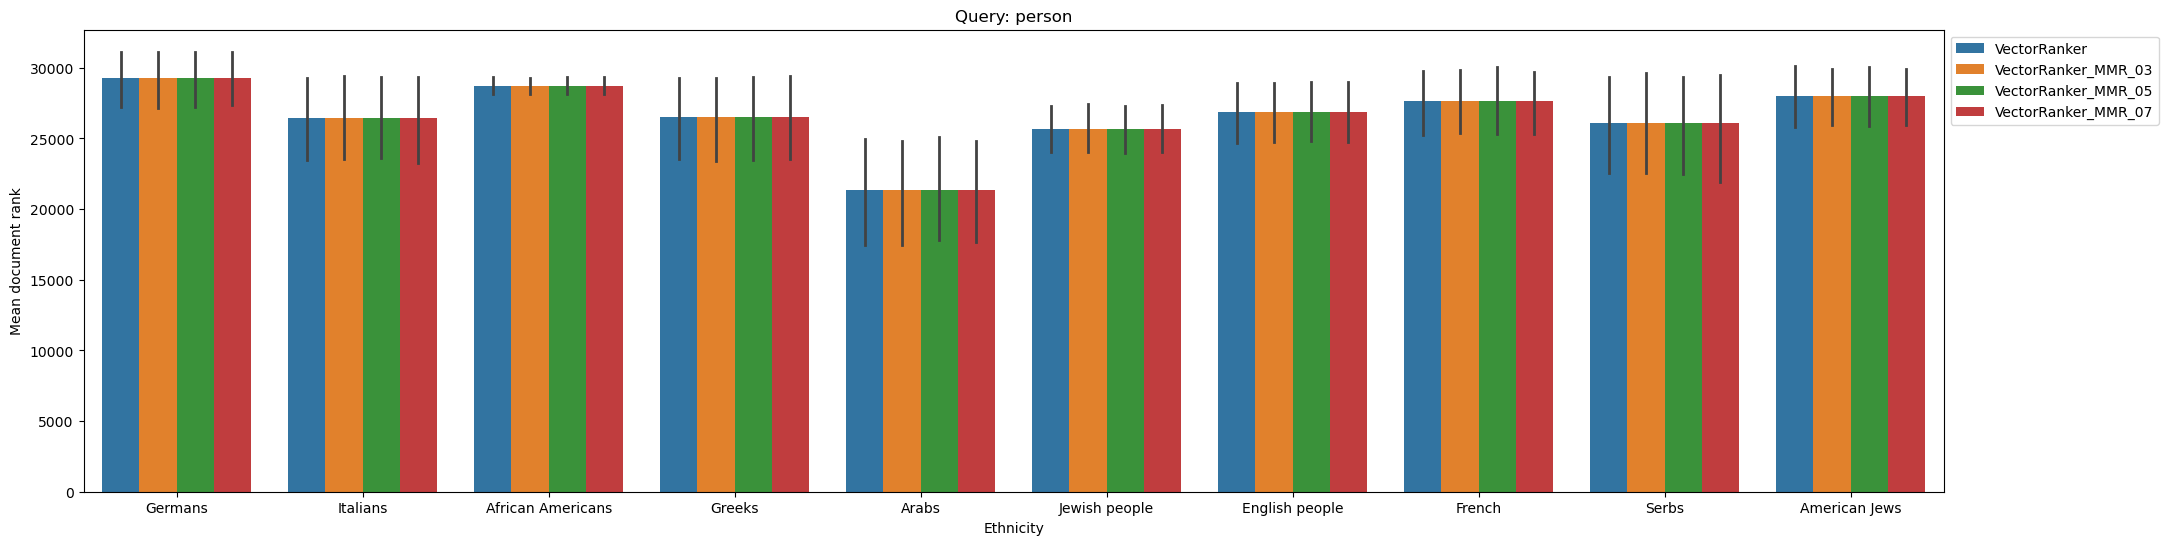

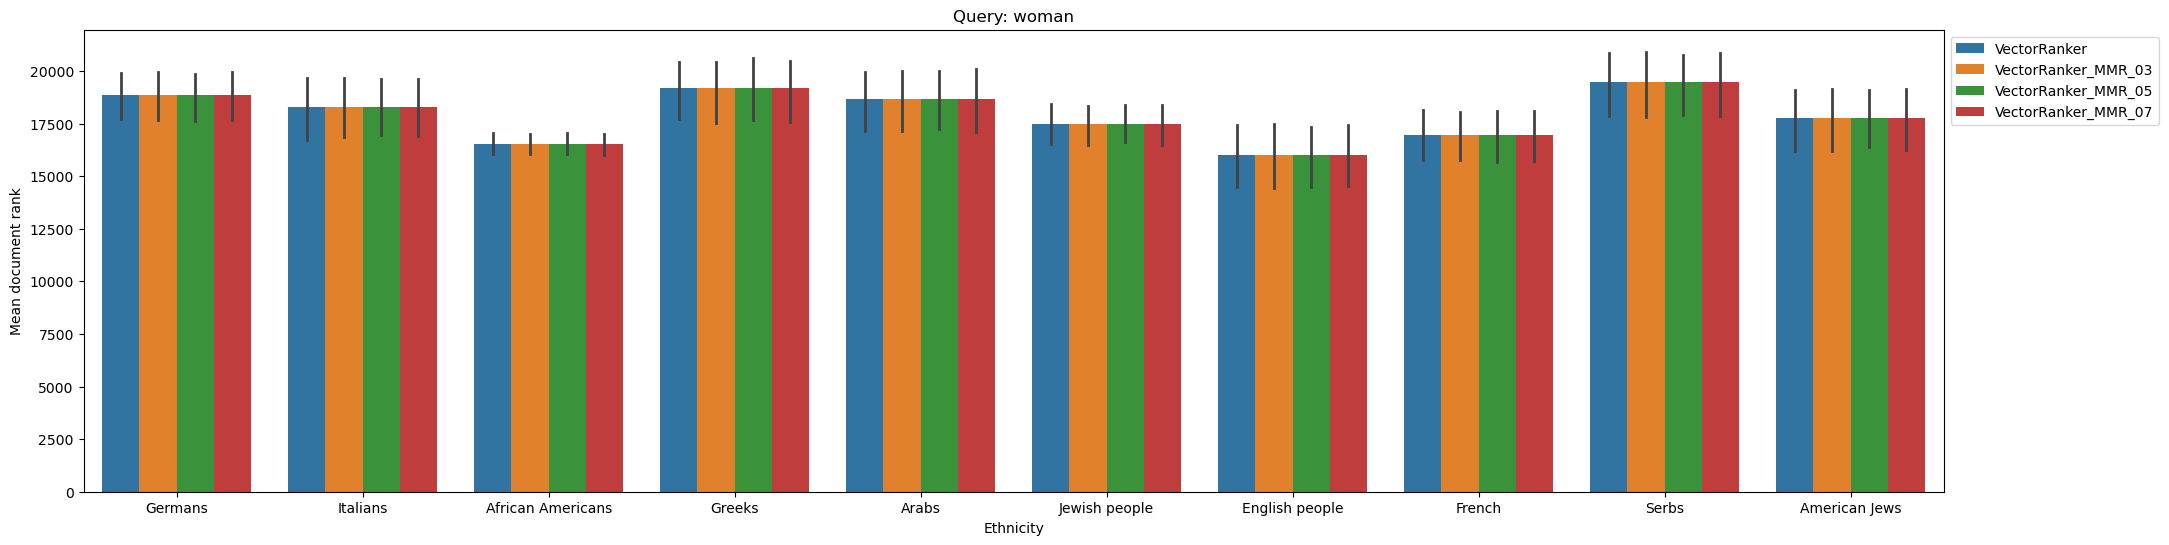

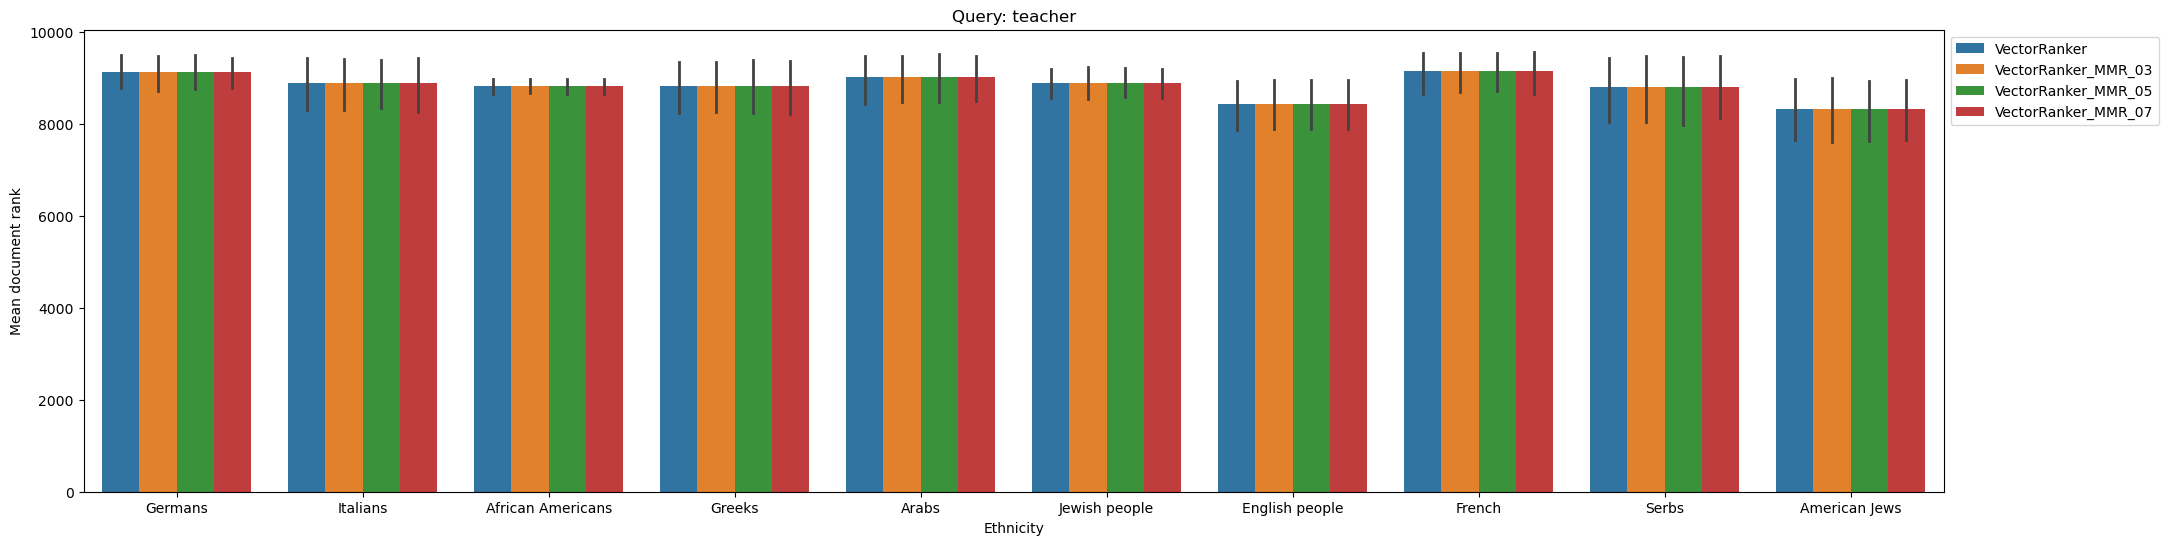

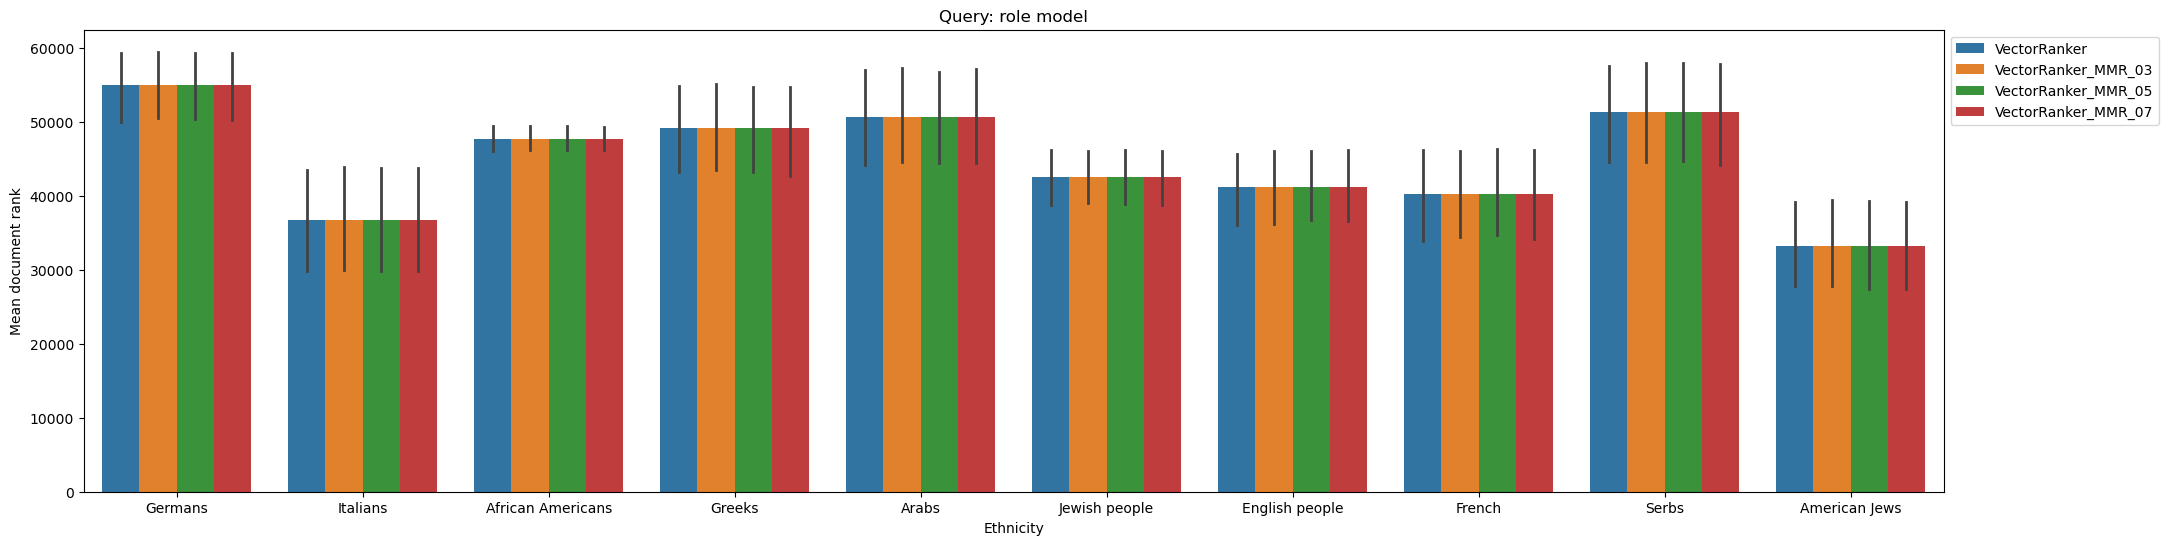

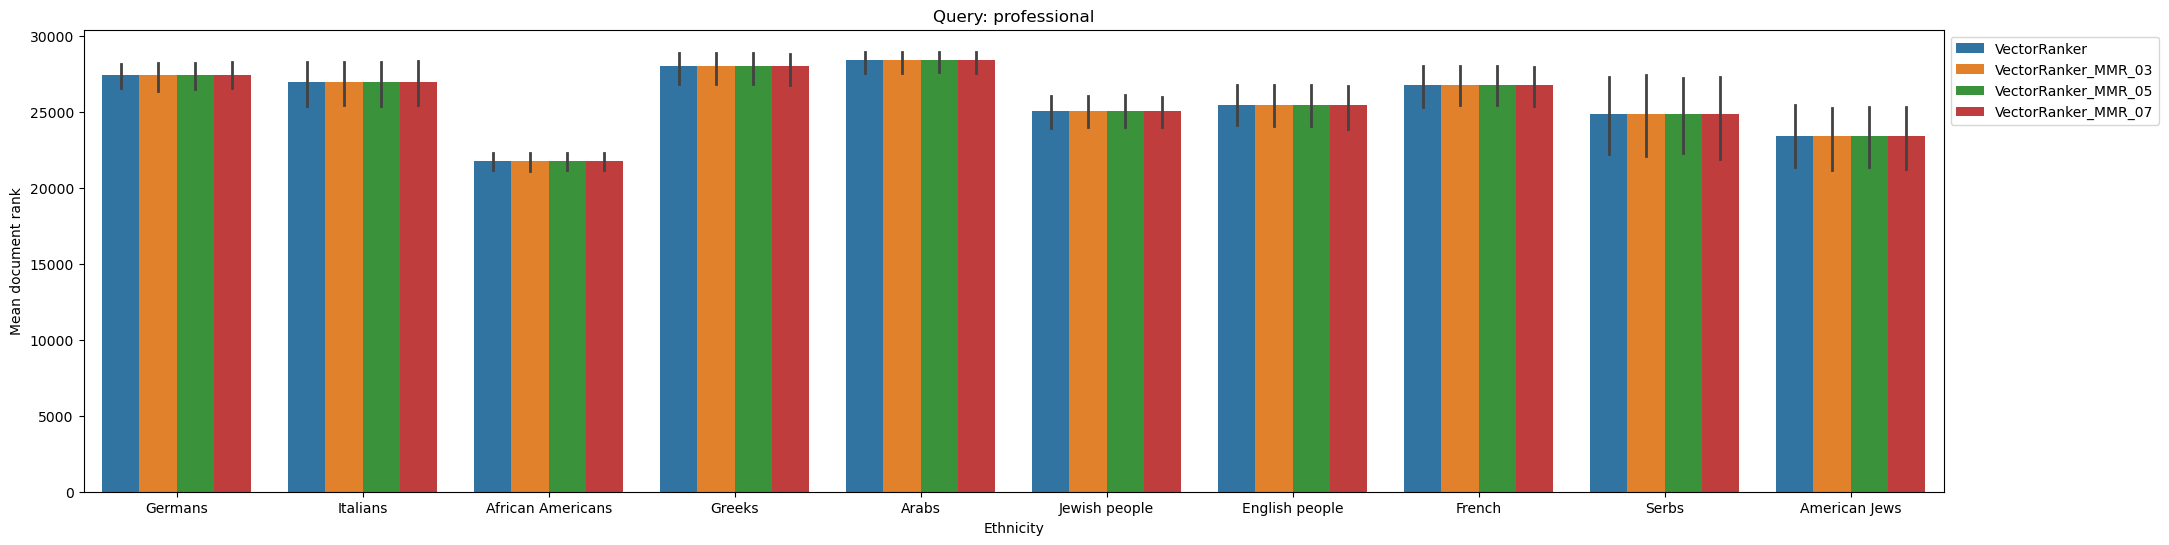

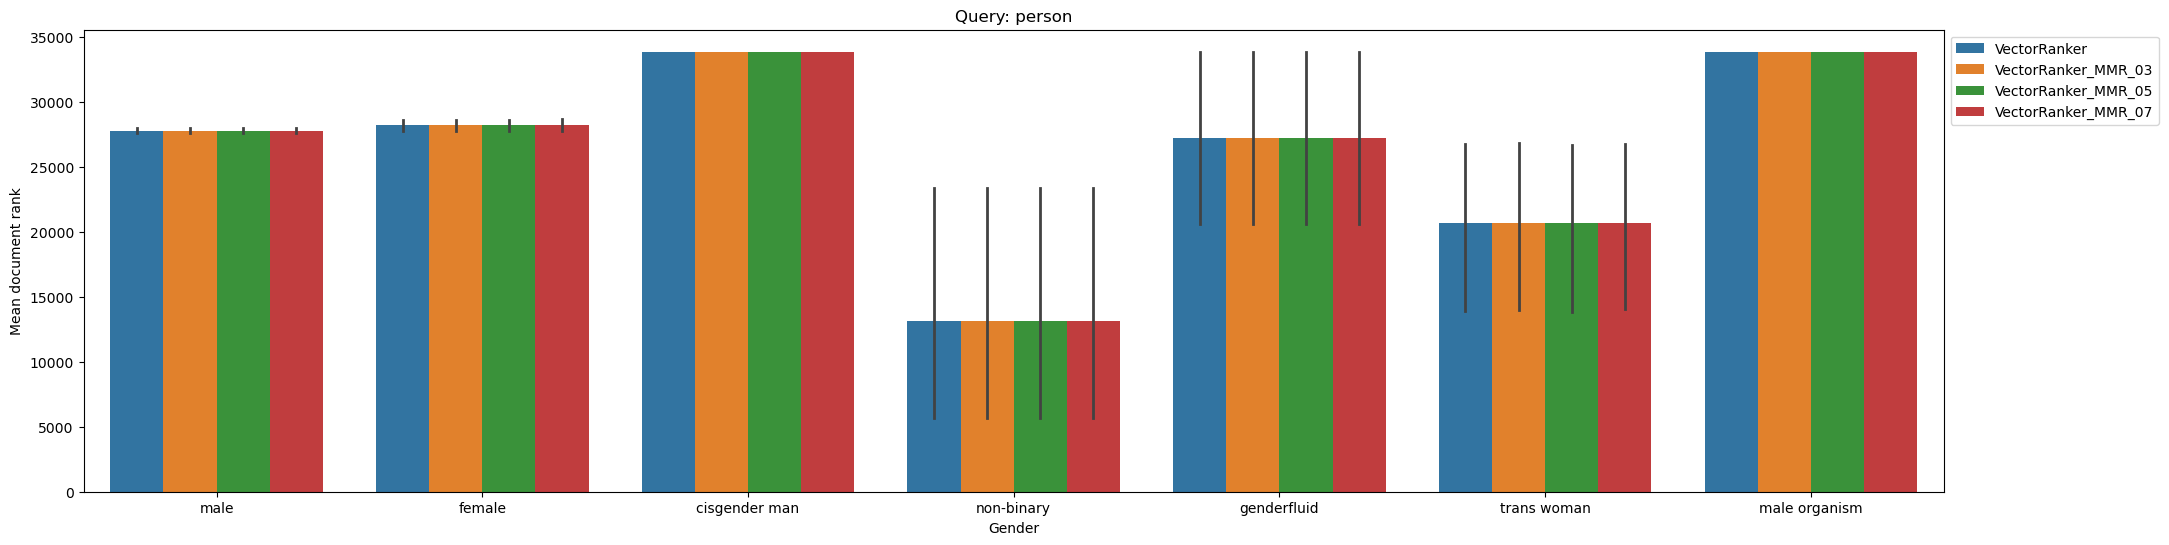

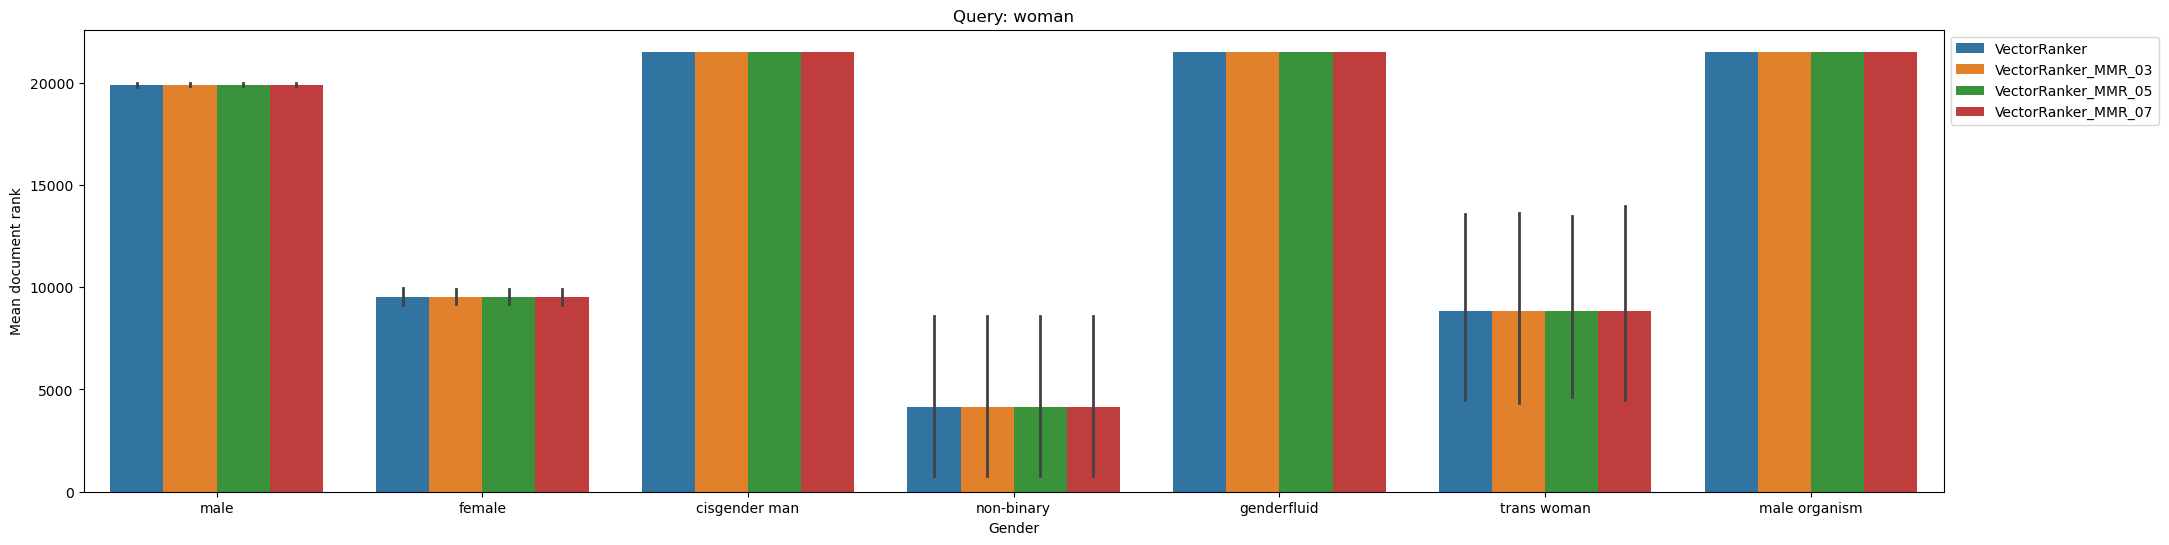

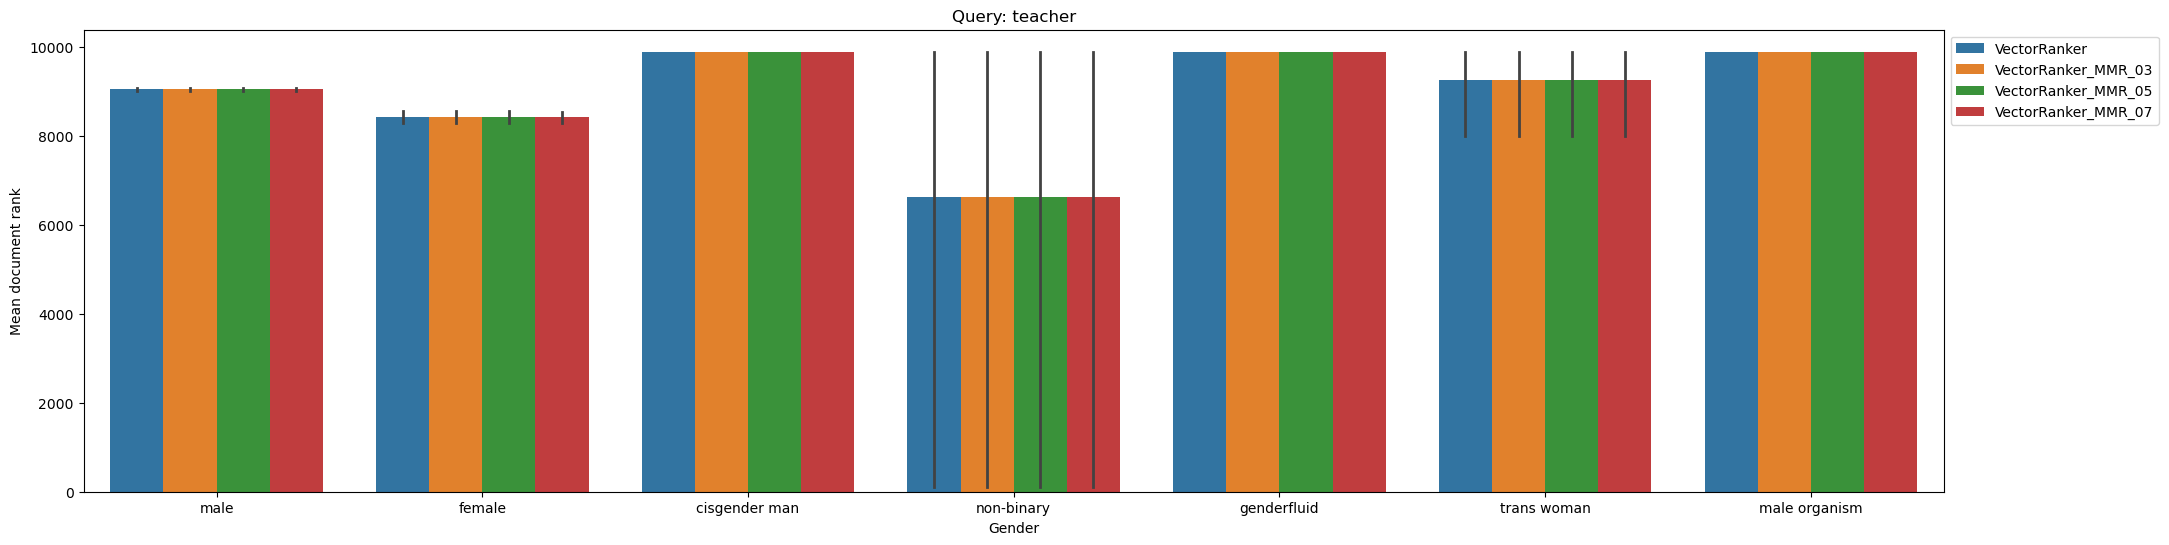

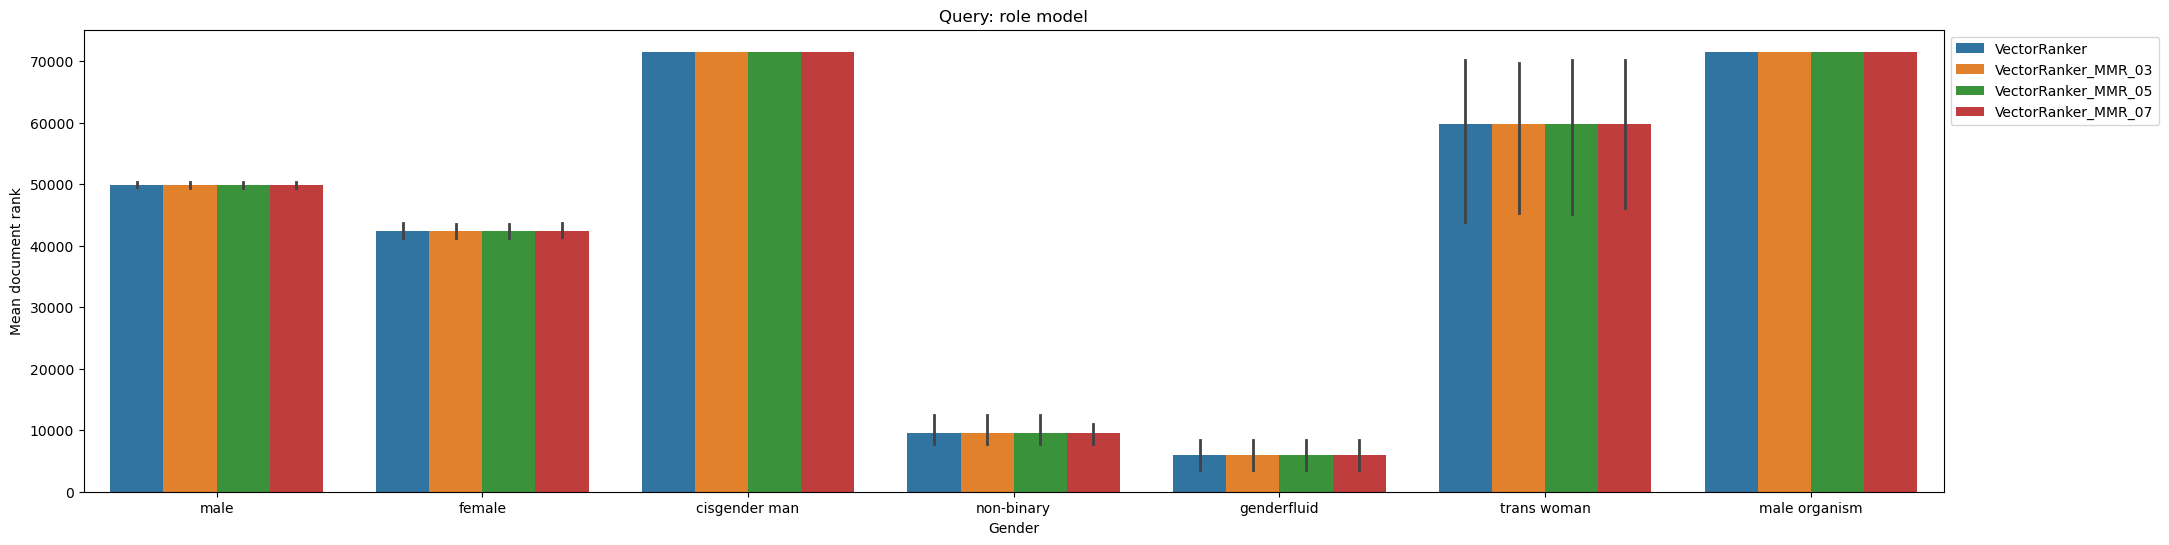

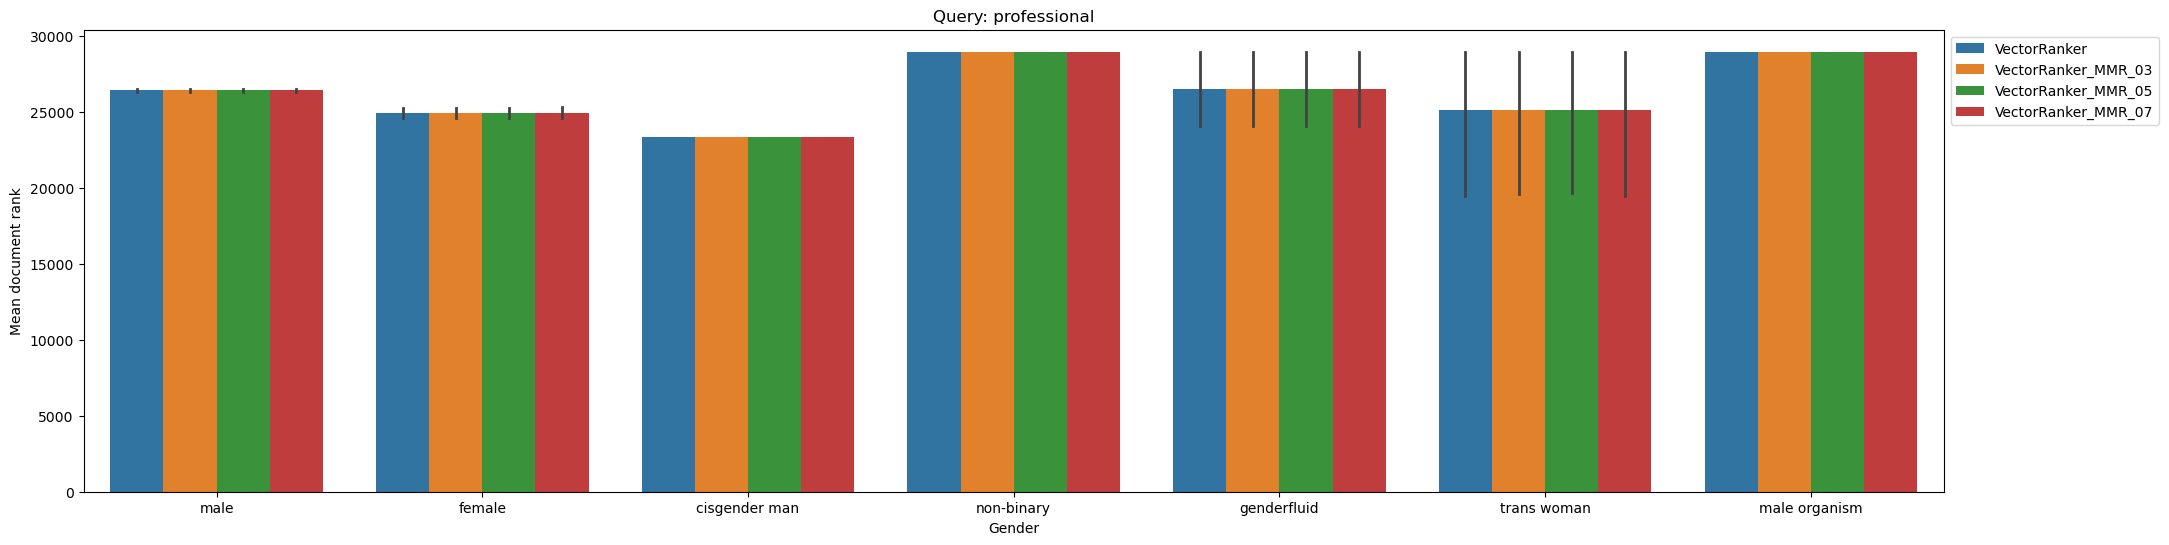

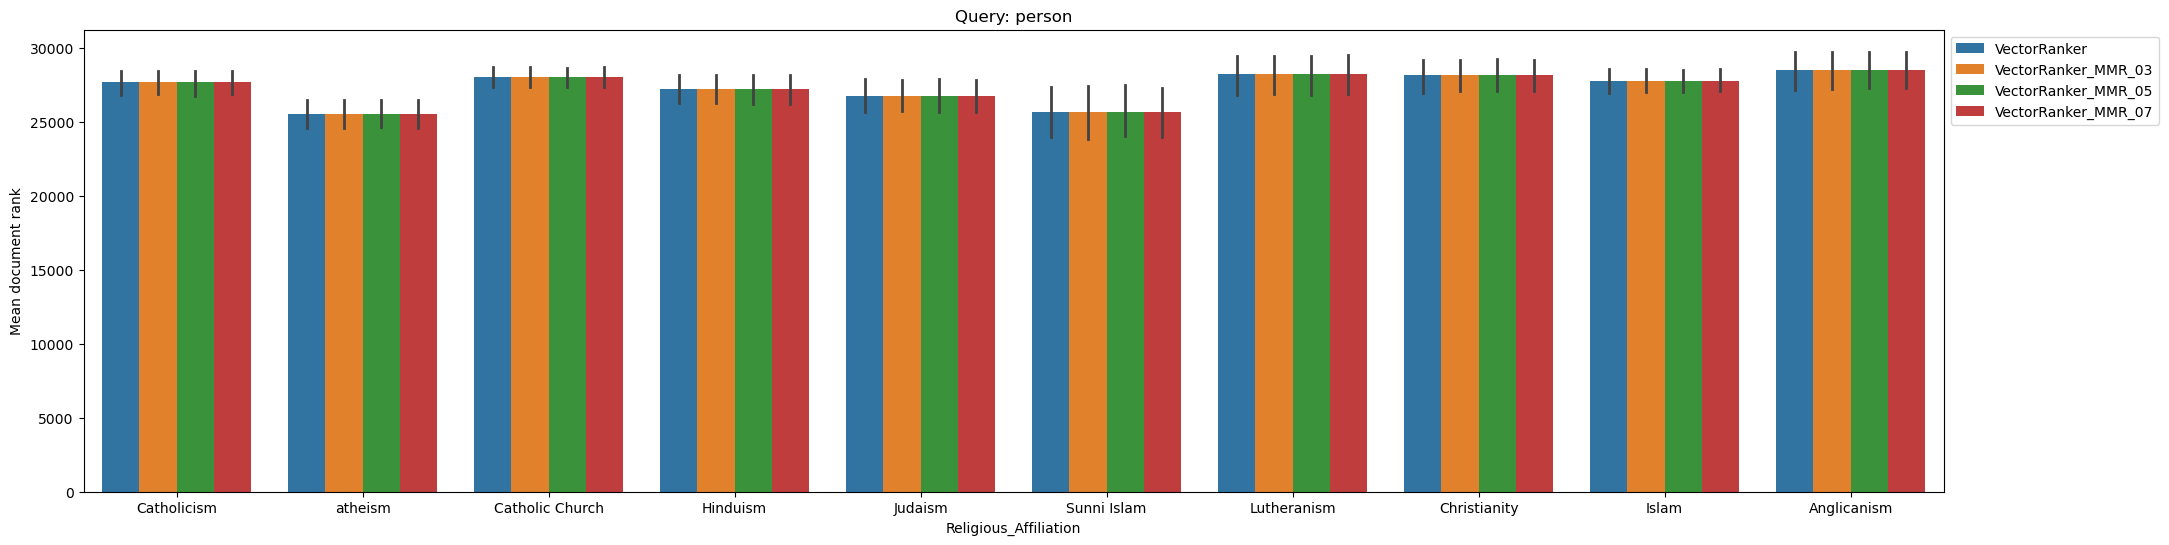

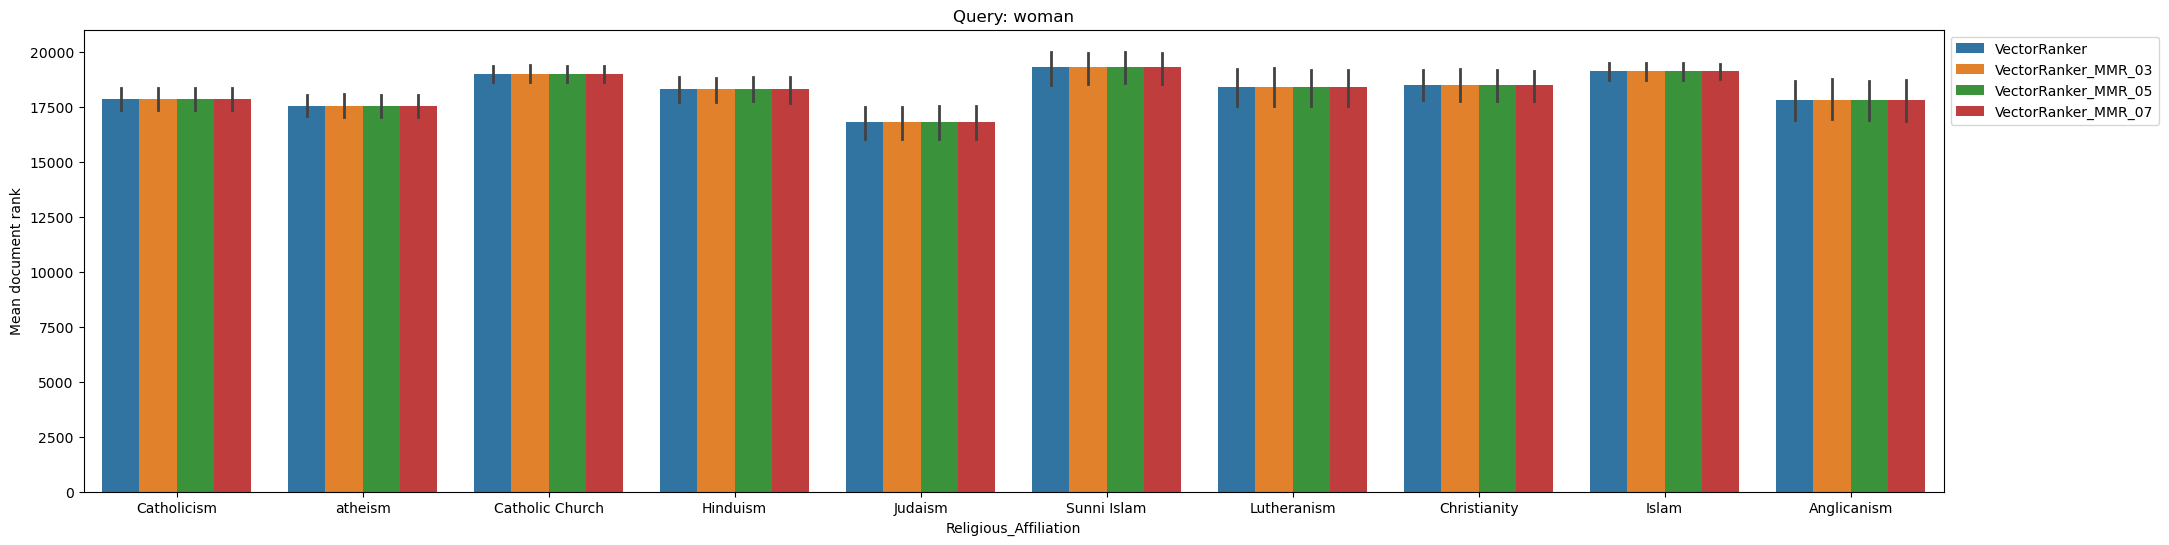

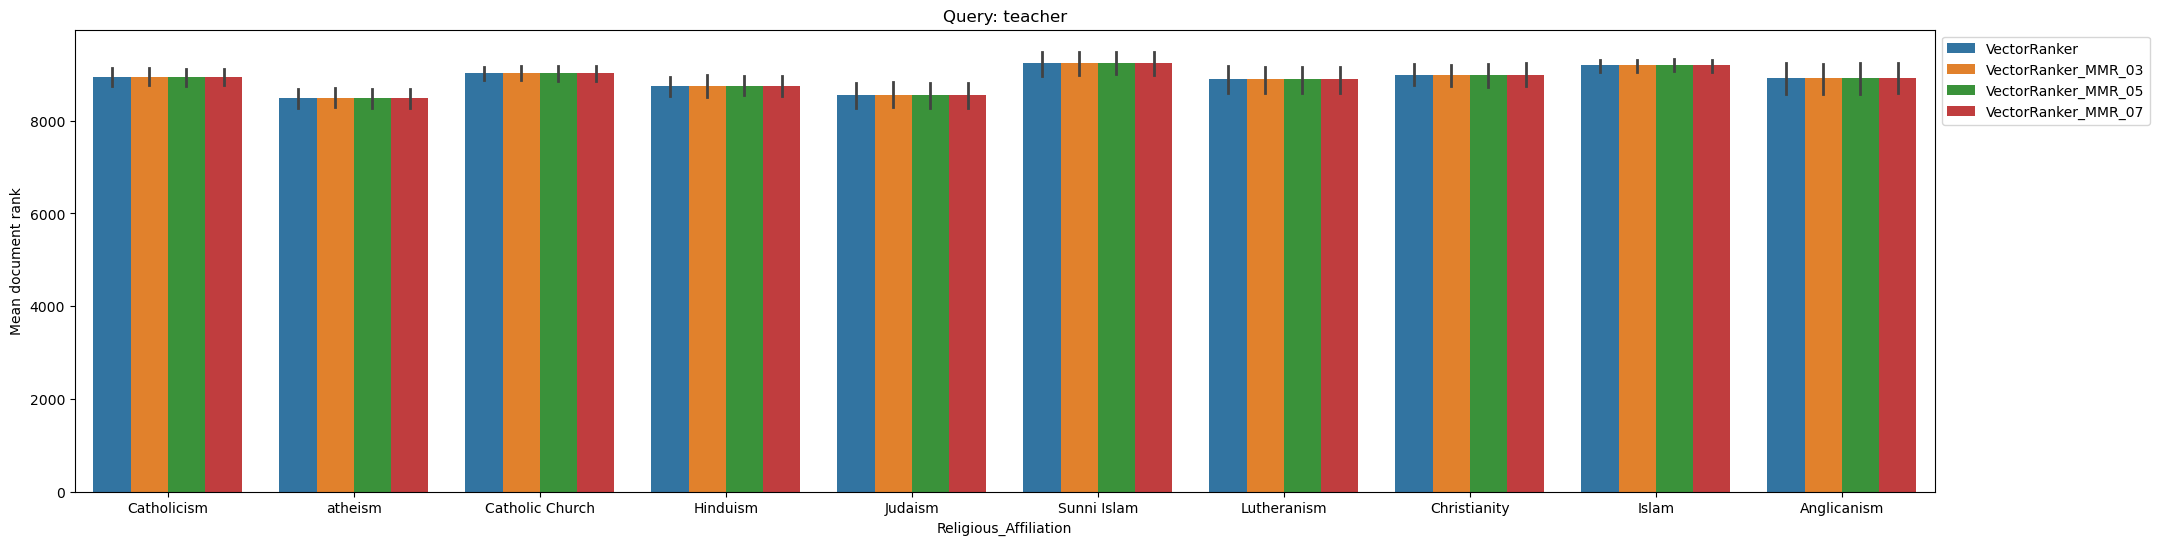

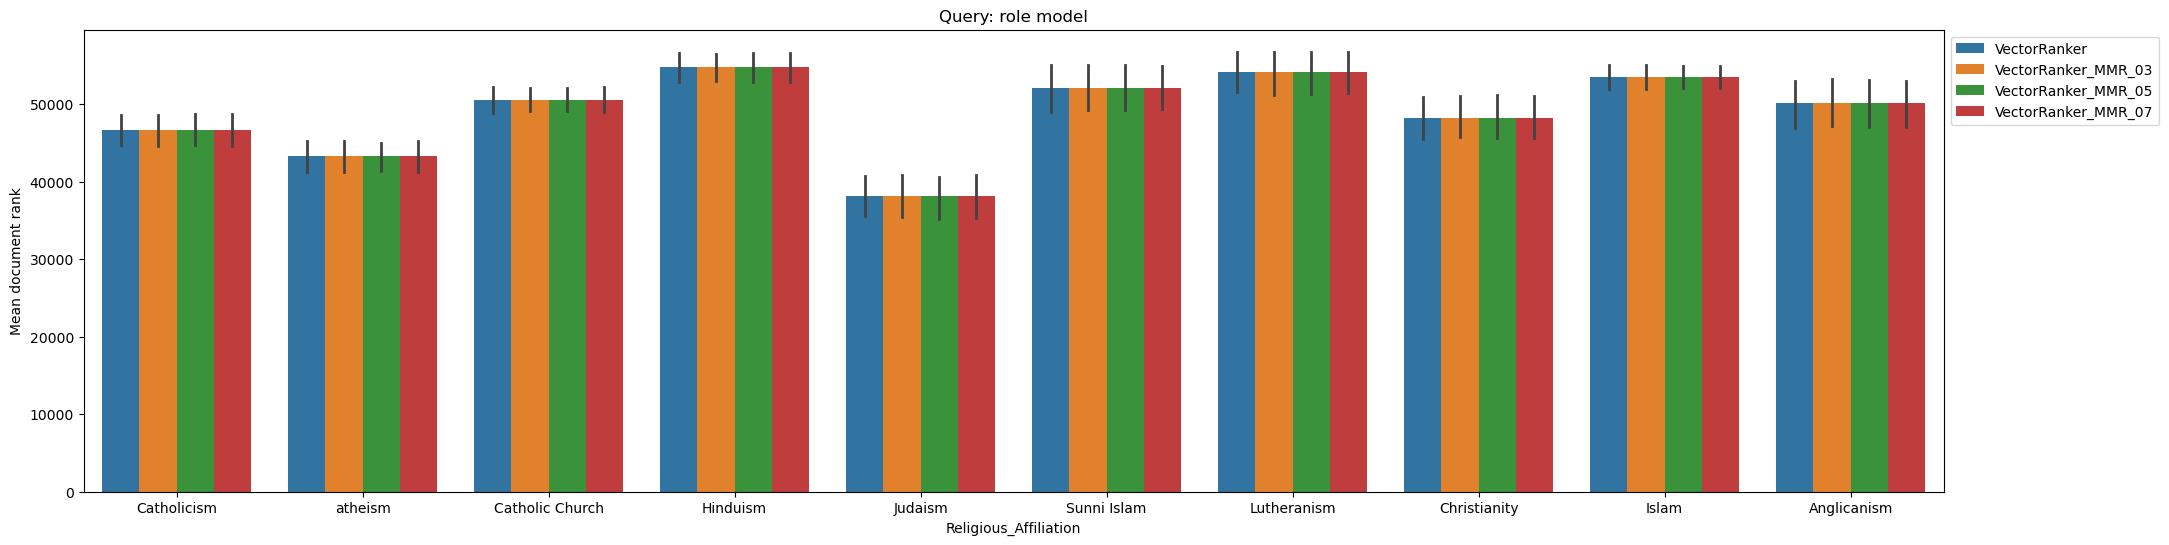

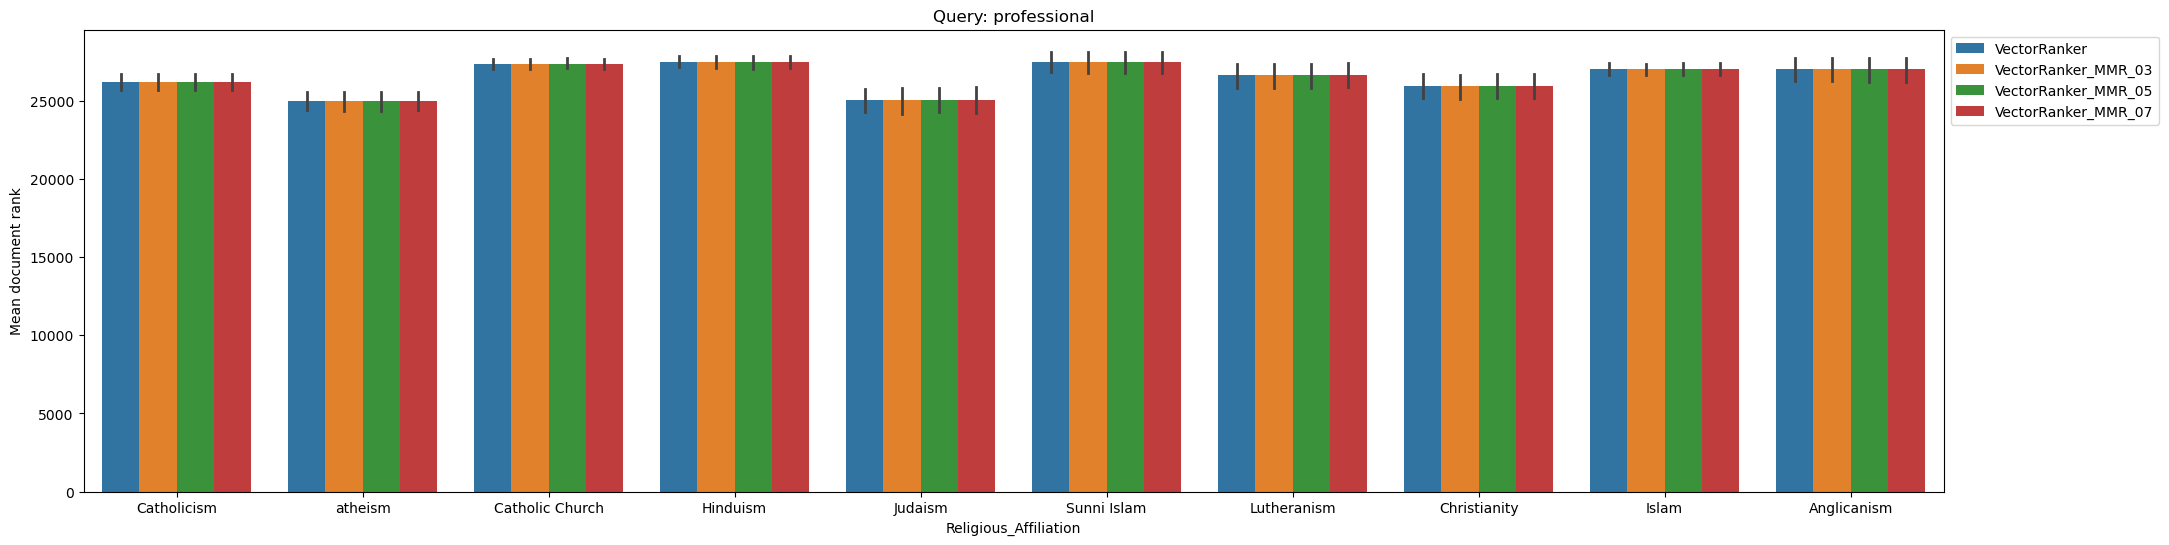

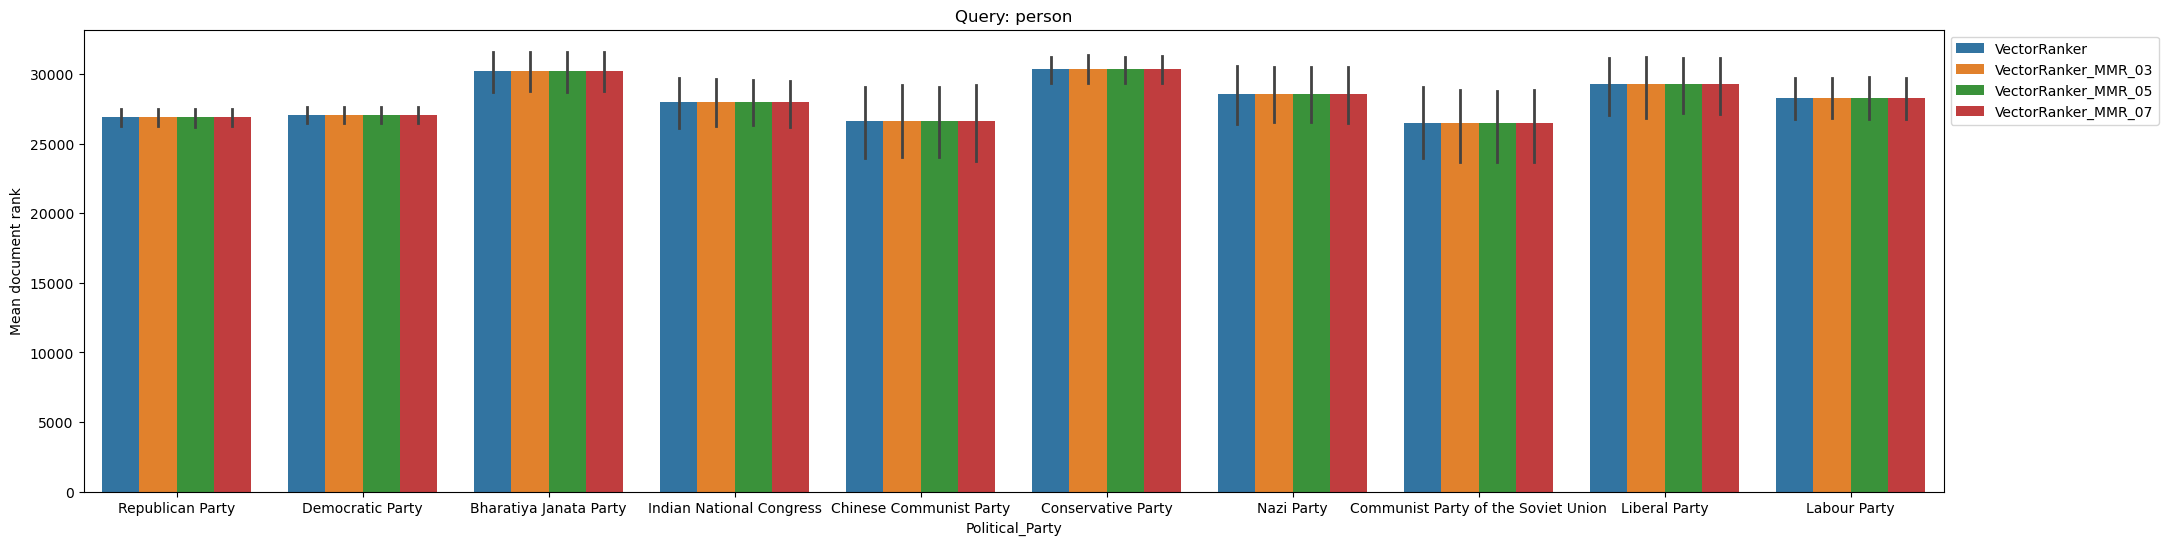

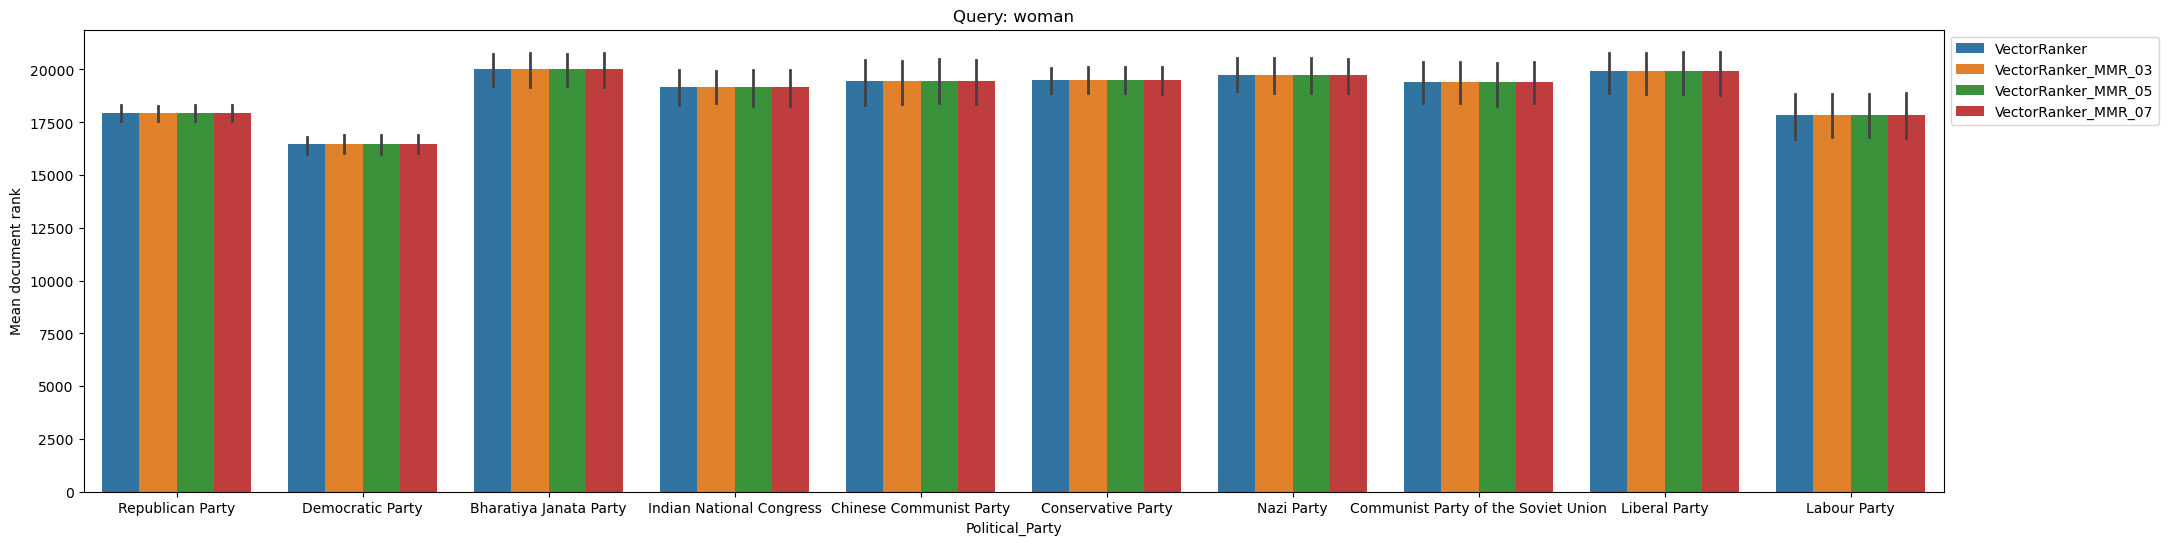

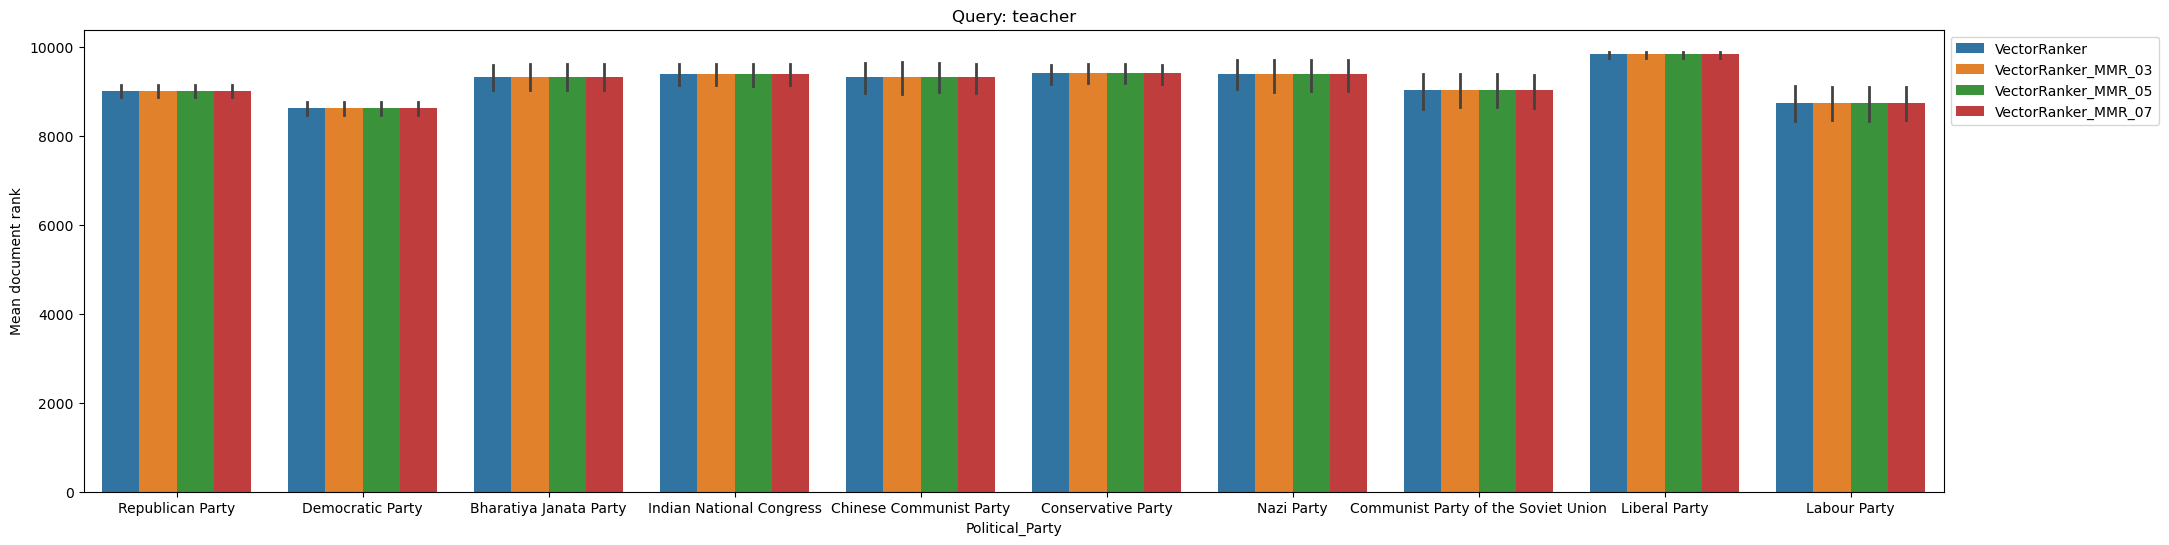

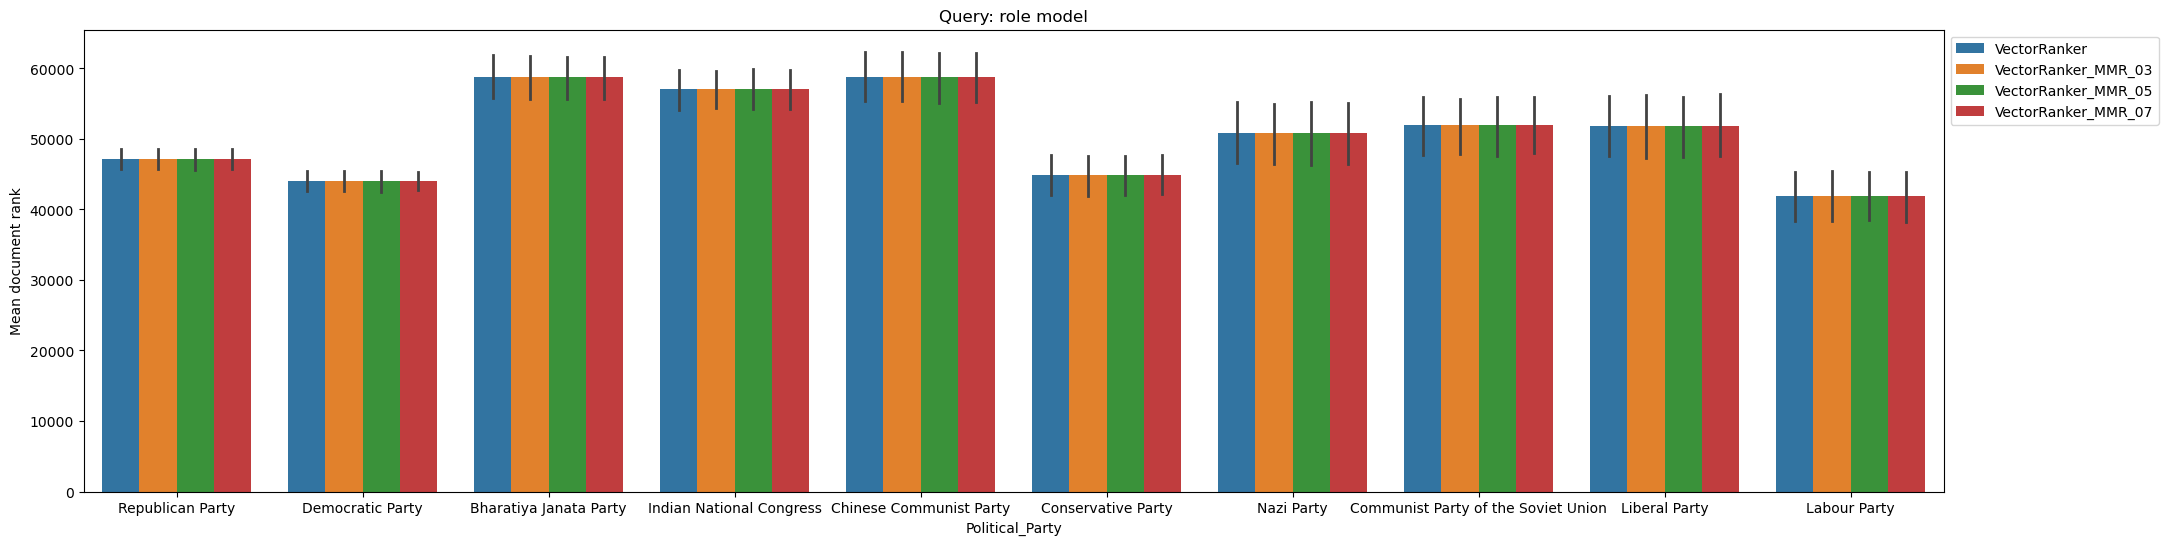

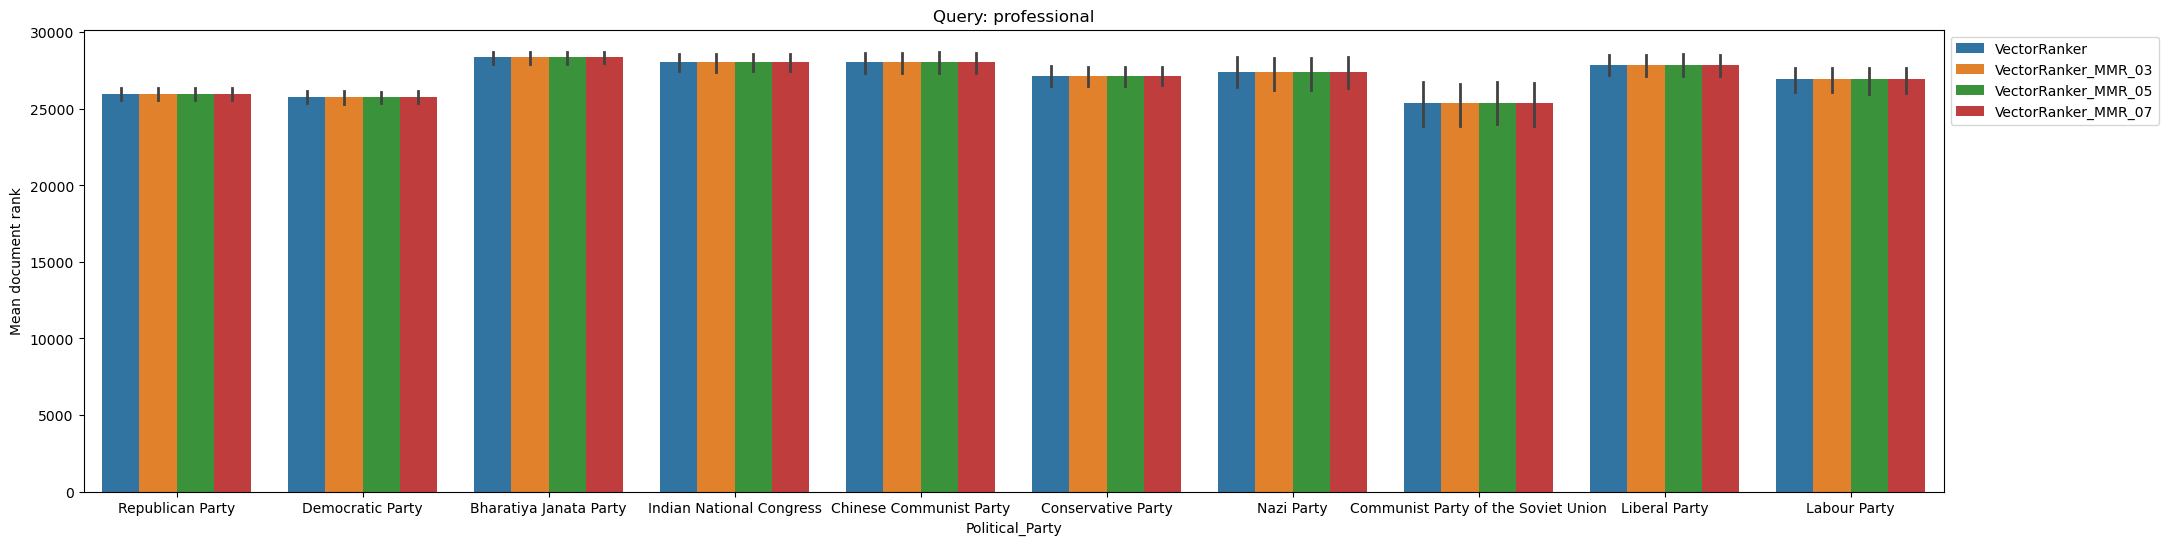

In [53]:
attr_names = ["Ethnicity", "Gender", "Religious_Affiliation", "Political_Party"]
for attr_name in attr_names:
    top_10_categories = top_10_attributes[attr_name]
    filtered_df = person_attr_df_rank[person_attr_df_rank[attr_name].isin(top_10_categories.keys())]
    for query in queries:
        new_df = []
        for model in pipe_name:
            model_df = filtered_df[["docid", model + "_" + query]].copy()
            model_df.columns = ["docid", "rank"]
            model_df["model"] = model
            model_df[attr_name] = filtered_df[attr_name]
            new_df.append(model_df)
        new_df = pd.concat(new_df)
        plt.figure(figsize=(24, 6))
        ax = sns.barplot(x=attr_name, y="rank", hue="model", data=new_df, errwidth=2)
        # ax.bar_label(ax.containers[0], fontsize=8, color='darkblue')
        # ax.bar_label(ax.containers[1], fontsize=8, color='darkorange')
        # ax.bar_label(ax.containers[2], fontsize=8, color='darkgreen')
        # ax.bar_label(ax.containers[3], fontsize=8, color='darkred')
        ax.set_title("Query: " + query)
        ax.set_ylabel("Mean document rank")
        ax.set_xlabel(attr_name)
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        # plt.savefig("figures/" + attr_name + "_" + query + ".png", bbox_inches='tight')

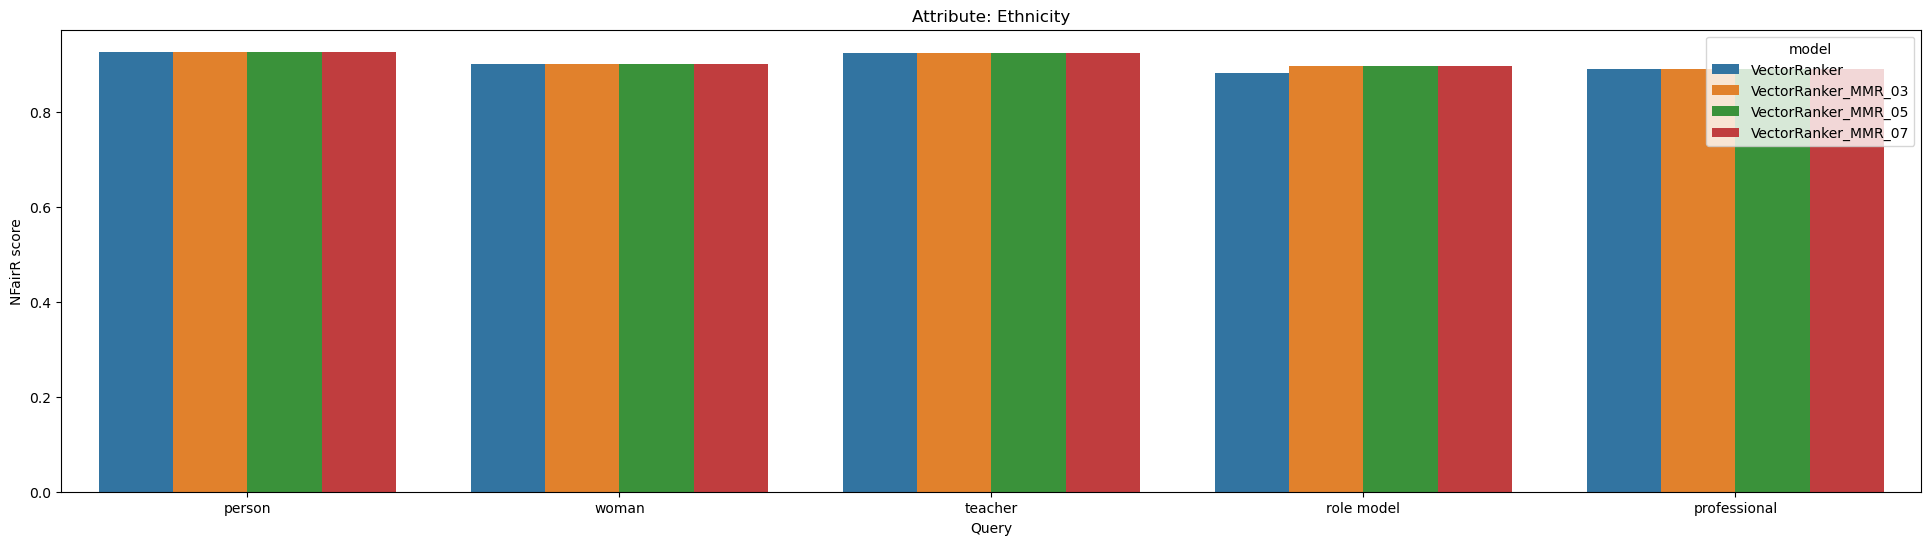

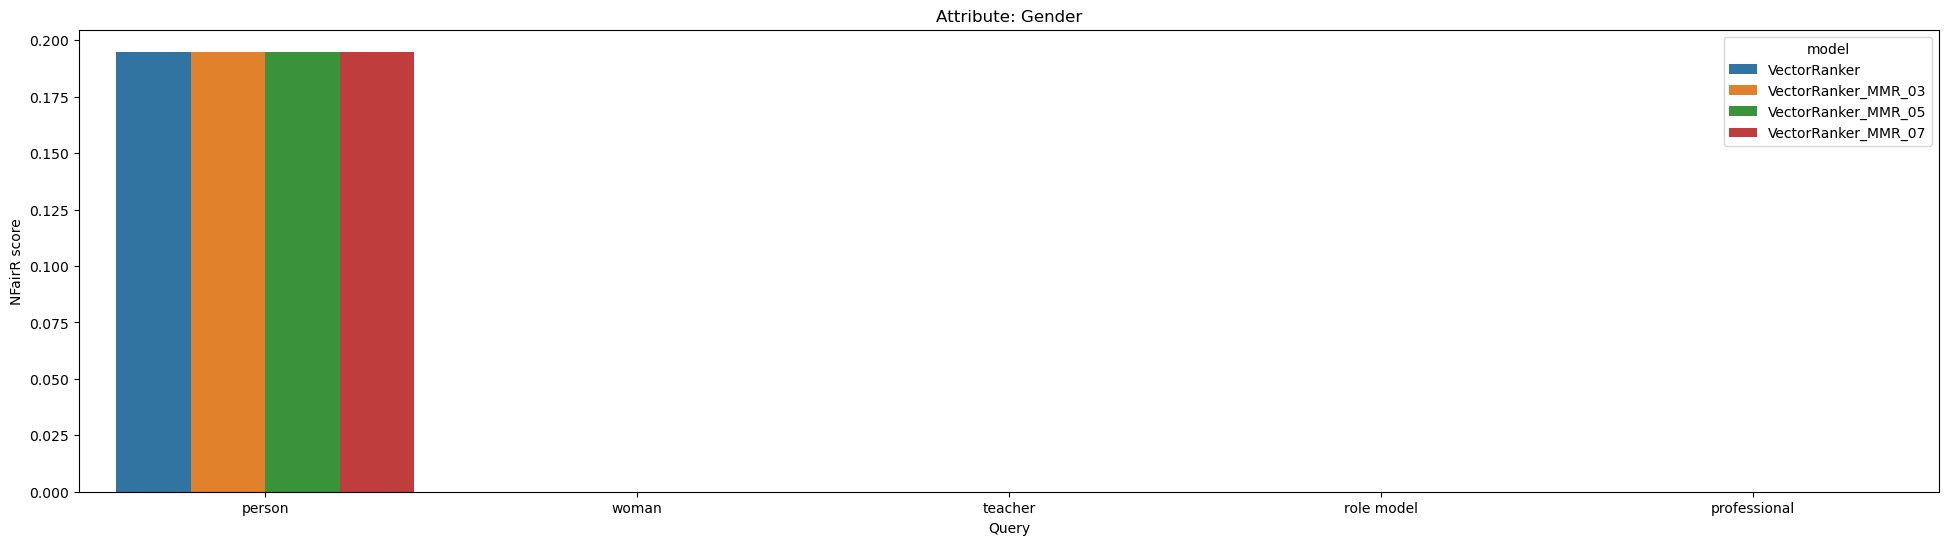

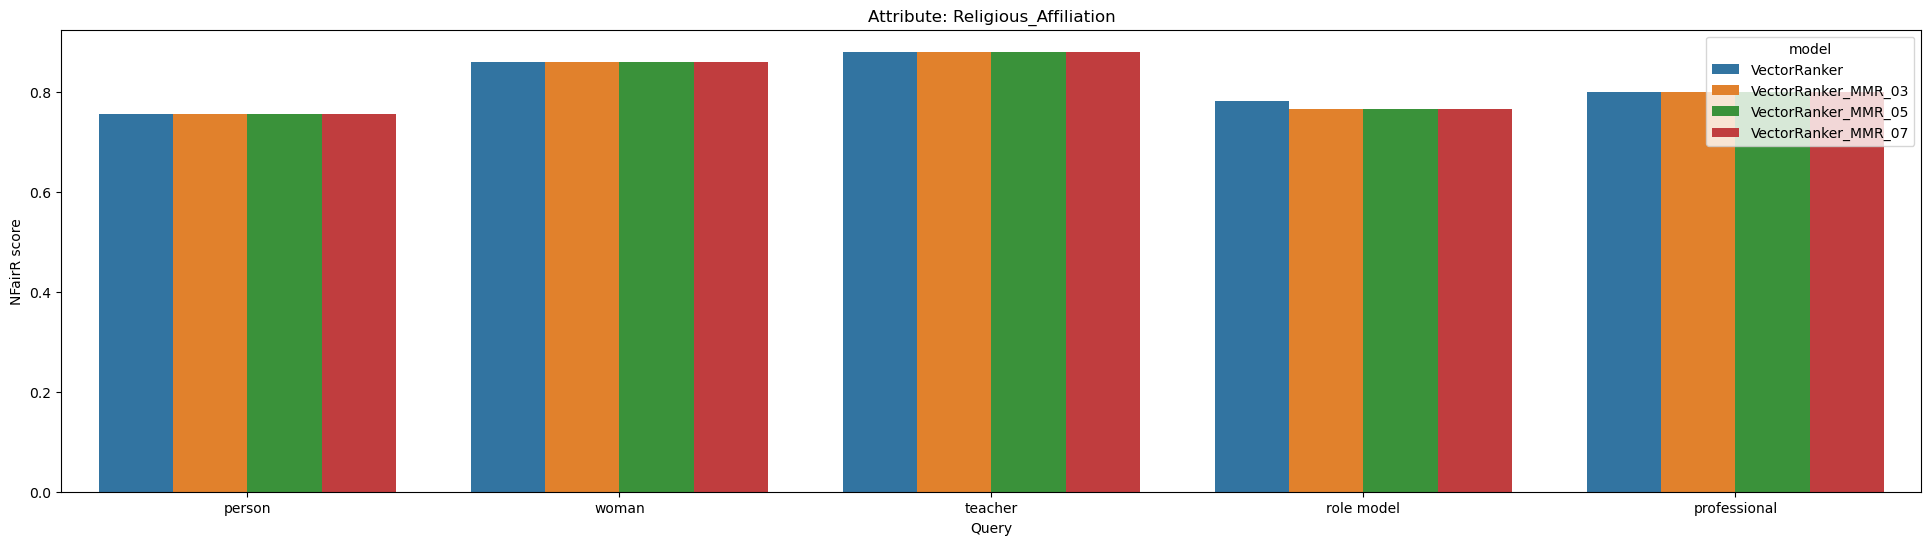

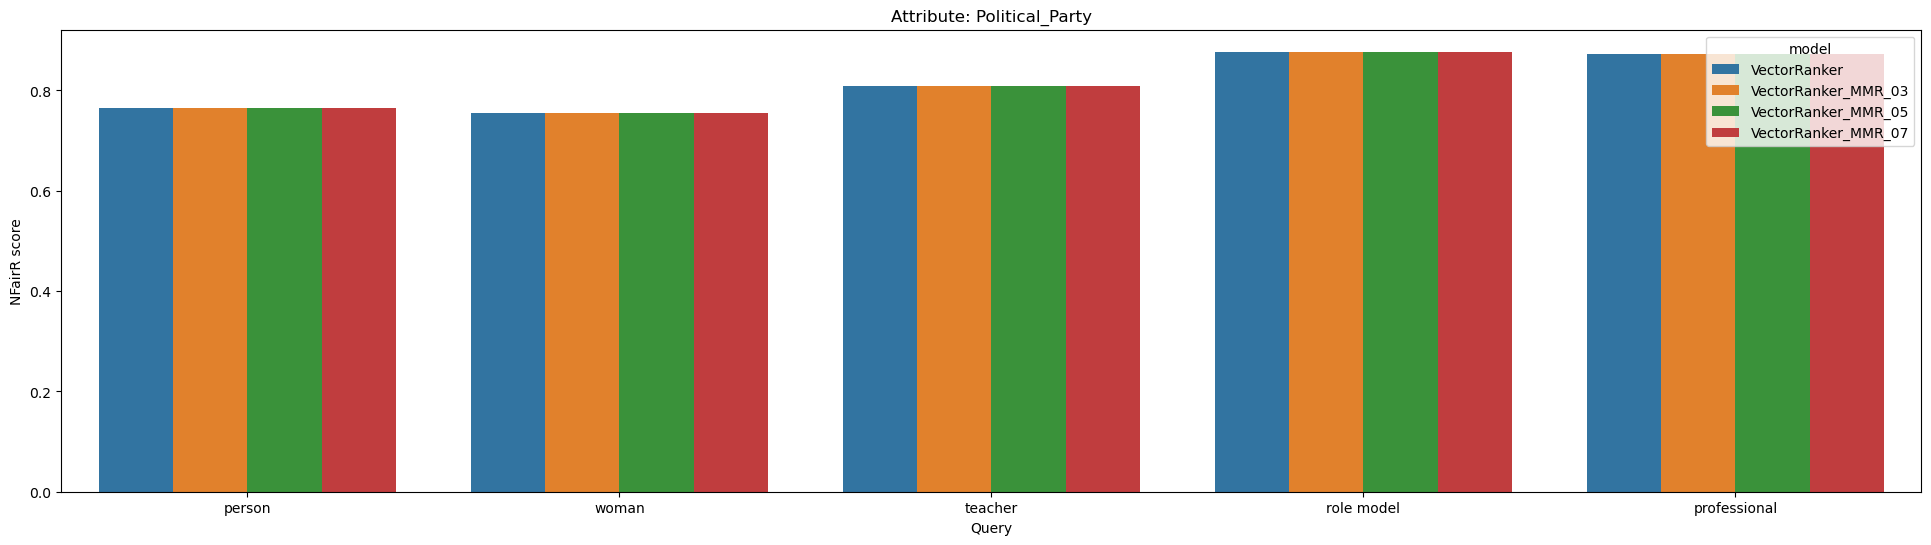

In [49]:
import os
from relevance import nfairr_score

if not os.path.exists("nfairr_figures"):
    os.makedirs("nfairr_figures")
attr_names = ["Ethnicity", "Gender", "Religious_Affiliation", "Political_Party"]
all_df = []
for attr_name in attr_names:
    filtered_df = person_attr_df_rank
    new_df = []
    for query in queries:
        for model in pipe_name:
            model_df = pd.DataFrame(columns=["model", 'attr', 'value', 'rank', 'query'])
            omega_values = filtered_df[attr_name].map(lambda x: 1 if x is np.nan else 0)
            omega_values = sorted(zip(omega_values, filtered_df[model + "_" + query]), key=lambda x: x[1])
            omega_values = [x[0] for x in omega_values]
            nfairr_val = nfairr_score(omega_values)
            model_df["model"] = [model]
            model_df['query'] = [query]
            model_df['attr'] = [attr_name]
            model_df['value'] = [nfairr_val]
            model_df['rank'] = np.sum(omega_values[:200])
            new_df.append(model_df)
    new_df = pd.concat(new_df)
    # print(new_df)
    plt.figure(figsize=(24, 6))
    ax = sns.barplot(x="query", y='value', hue='model', data=new_df, errwidth=2)
    # ax.bar_label(ax.containers[0], fontsize=8, color='darkblue')
    # ax.bar_label(ax.containers[1], fontsize=8, color='darkorange')
    # ax.bar_label(ax.containers[2], fontsize=8, color='darkgreen')
    # ax.bar_label(ax.containers[3], fontsize=8, color='darkred')
    ax.set_ylabel("NFairR score")
    ax.set_xlabel("Query")
    ax.set_title("Attribute: " + attr_name)
    # plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.savefig("nfairr_figures/" + attr_name + ".png", bbox_inches='tight')
    all_df.append(new_df)
    # break
all_df = pd.concat(all_df)

In [50]:
all_df.to_csv("nfairr_scores.csv", index=False)

In [7]:

import pandas as pd
# from scipy.stats import f_oneway
from relevance import nfairr_score

person_attr_df_rank = pd.read_csv("person-attributes-ranked.csv")
attr_names = ["Ethnicity", "Gender", "Religious_Affiliation", "Political_Party"]

rank_columns = person_attr_df_rank.columns[6:]
rank_columns = [name for name in rank_columns if "value" not in name]

q1_columns = [[name[:4], name[:4] + "_fstat", name[:4] + "_std"] for name in attr_names]
q1_columns = [item for sublist in q1_columns for item in sublist]

# mark = (person_attr_df_rank[rank_columns] == person_attr_df_rank[rank_columns].max(axis=0)).copy()
# person_attr_df_rank[rank_columns][mark] = np.nan

q1_df = pd.DataFrame(columns=q1_columns, index=rank_columns)
for attr_name in attr_names:
    top_10_categories = top_10_attributes[attr_name]
    filtered_df = person_attr_df_rank[person_attr_df_rank[attr_name].isin(top_10_categories.keys())]
    lambda_df = lambda k: filtered_df[filtered_df[attr_name] == k].copy()
    groups_val = [lambda_df(k) for k in top_10_categories.keys()]
    for rank_col in rank_columns:
        values = [group[rank_col] for group in groups_val]
        f_stat, p_val = f_oneway(*values)
        q1_df.loc[rank_col, attr_name[:4]] = "T" if p_val < 0.05 else "F"
        q1_df.loc[rank_col, attr_name[:4] + "_fstat"] = round(f_stat, 3)
        mean_values = [value.mean() for value in values]
        q1_df.loc[rank_col, attr_name[:4] + "_std"] = round(np.std(mean_values), 3)
# q1_df.to_csv("q1_rank.csv")
q1_df

,Ethn,Ethn_fstat,Ethn_std,Gend,Gend_fstat,Gend_std,Reli,Reli_fstat,Reli_std,Poli,Poli_fstat,Poli_std
VectorRanker_person,T,4.453,2081.511,T,2.368,6820.436,T,3.805,992.561,T,4.766,1353.933
VectorRanker_MMR_03_person,T,4.453,2081.511,T,2.368,6820.435,T,3.805,992.561,T,4.766,1353.933
VectorRanker_MMR_05_person,T,4.453,2081.511,T,2.368,6820.435,T,3.805,992.561,T,4.766,1353.933
VectorRanker_MMR_07_person,T,4.453,2081.511,T,2.368,6820.435,T,3.805,992.561,T,4.766,1353.933
VectorRanker_woman,T,3.125,1112.473,T,1161.685,6934.964,T,7.291,738.446,T,13.522,1098.715
VectorRanker_MMR_03_woman,T,3.125,1112.473,T,1161.683,6934.962,T,7.291,738.446,T,13.522,1098.712
VectorRanker_MMR_05_woman,T,3.125,1112.473,T,1161.682,6934.96,T,7.291,738.446,T,13.522,1098.707
VectorRanker_MMR_07_woman,T,3.125,1112.473,T,1161.682,6934.96,T,7.291,738.446,T,13.522,1098.708
VectorRanker_teacher,F,0.988,255.42,T,21.392,1095.278,T,5.719,235.853,T,7.415,343.156
VectorRanker_MMR_03_teacher,F,0.988,255.42,T,21.393,1095.28,T,5.719,235.853,T,7.415,343.161


#### Problem 6

In [13]:
class TestVectorRanker:
    def __init__(self, ranker: VectorRanker, mmr_lambda=1.0):
        self.ranker = ranker
        self.mmr_lambda = mmr_lambda
    
    def query(self, query):
        return self.ranker.query(query, mmr_lambda=self.mmr_lambda)

In [14]:
cescorer = CrossEncoderScorer(raw_text_dict)
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
            preprocessor, stopwords, recognized_categories,
            network_feats, cescorer)

hyperparams_list = [0.3, 0.5, 0.7]

results_info = {}
vec_ranker = VectorRanker(bi_encoder_name, encoded_docs, document_ids)

name_hyperparam = lambda hyperparams: f"VectorRanker_MMR_{hyperparams}"

for hyperparam in hyperparams_list:
    print(f"MMR Lambda: {hyperparam}")
    base_ranker = L2RRanker(main_index, title_index, preprocessor, stopwords, vec_ranker, fe)
    base_ranker.model.load("pipeline_1.model.txt")
    pipeline = TestVectorRanker(base_ranker, hyperparam)
    result_info = run_relevance_tests(RELEVANCE_TEST_DATA, pipeline)
    results_info[name_hyperparam(hyperparam)] = result_info

MMR Lambda: 0.3


100%|██████████| 37/37 [03:44<00:00,  6.07s/it]


MMR Lambda: 0.5


100%|██████████| 37/37 [04:07<00:00,  6.70s/it]


MMR Lambda: 0.7


100%|██████████| 37/37 [03:58<00:00,  6.45s/it]


In [16]:
prev_infos = {}
with open("q5_results_info.json", "r") as f:
    prev_infos = json.load(f)

In [17]:
for k, v in prev_infos.items():
    if "model" not in k:
        results_info[k] = v

In [19]:
results_info['hw4_l2r'] = prev_infos['model_1_0.5_0.5']
print(results_info['hw4_l2r'])

{'map': 0.06590148924507287, 'ndcg': 0.33724257324688867, 'map_scores': [0, 0.1111111111111111, 0, 0, 0.041666666666666664, 0.004273504273504273, 0.008695652173913044, 0.05714285714285714, 1.0, 0, 0, 0, 0.02, 0.0125, 0, 0, 0, 0.009523809523809523, 0.1264367816091954, 0, 0.14215686274509803, 0.007518796992481203, 0, 0, 0.125, 0, 0.27777777777777773, 0, 0.013888888888888888, 0.015384615384615385, 0, 0, 0, 0.020833333333333332, 0.3333333333333333, 0.1111111111111111, 0], 'ndcg_scores': [0.6542932618260382, 0.40115865730193656, 0.20231816153401244, 0.2, 0.3522506110165194, 0.25333266320965975, 0.31418795826238954, 0.3328217182211326, 0.49240925935130425, 0.22944928813745744, 0.22328753654806685, 0.3321210897820781, 0.28386162443739044, 0.2785679533547763, 0.2247297706750087, 0.37160712127113926, 0.24940464878744825, 0.26737454965763163, 0.6478361155493783, 0.2476458766073178, 0.5628323756055789, 0.26034179409746383, 0.3501719700105136, 0.22577108972438142, 0.4429171752190067, 0.29049008938

In [20]:
with open("hw5_q6_results_info.json", "w") as f:
    json.dump(results_info, f)

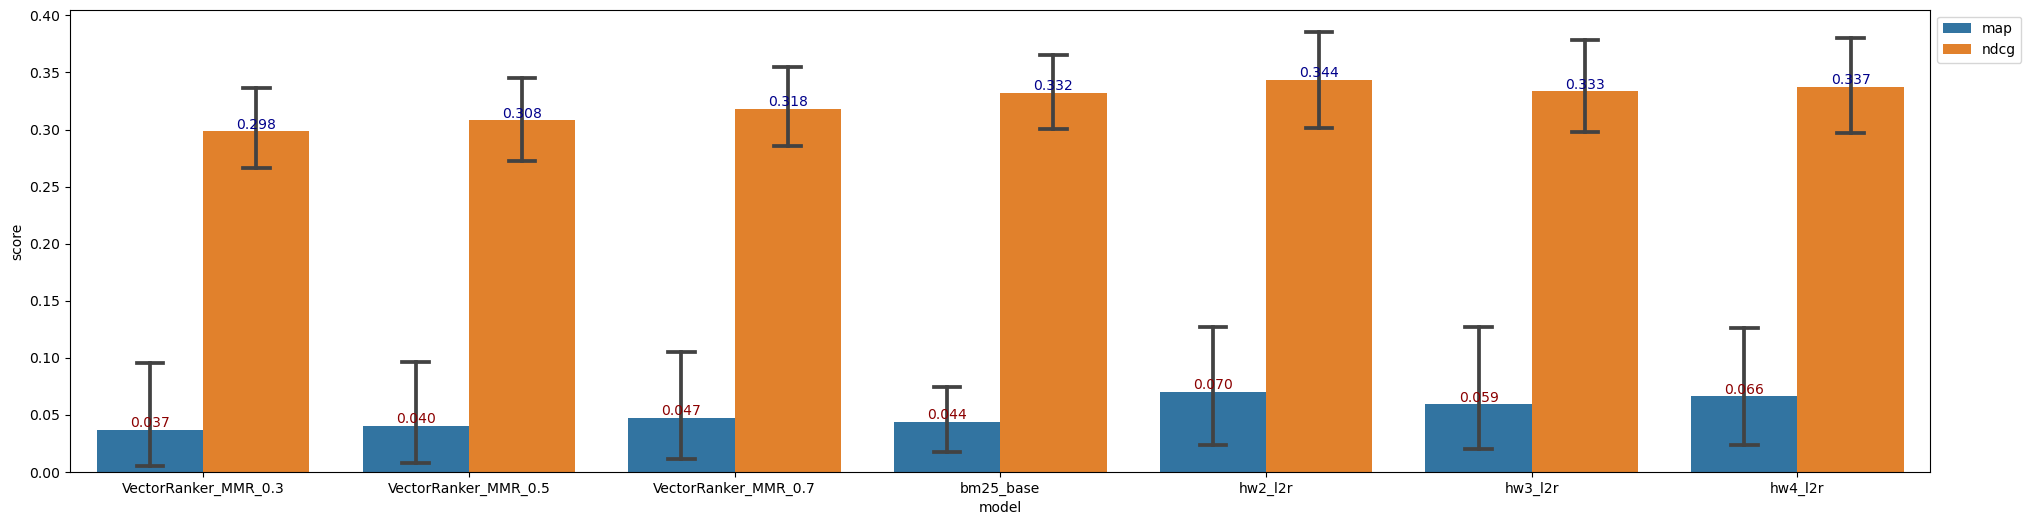

In [21]:
metric_add_func = lambda x, name: [(name, v) for v in x]
pipeline_df = pd.DataFrame(results_info).transpose().reset_index().rename(columns={'index': 'model'})
pipeline_df['score'] = pipeline_df[['map_scores', 'ndcg_scores']].apply(lambda x: metric_add_func(x[0], 'map') + metric_add_func(x[1], 'ndcg'), axis=1)
pipeline_df = pipeline_df.explode('score')
pipeline_df.drop(columns=['map', 'ndcg', 'map_scores', 'ndcg_scores'], inplace=True)
pipeline_df['metric'] = pipeline_df['score'].apply(lambda x: x[0])
pipeline_df['score'] = pipeline_df['score'].apply(lambda x: x[1])
pipeline_df['model'] = pipeline_df['model'].apply(lambda x: "pipeline_2" if x == "p5_pipeline" else x)
plt.figure(figsize=(24, 6))
ax = sns.barplot(data=pipeline_df, x='model', y='score', hue='metric', capsize=.1, errorbar='ci')
ax.bar_label(ax.containers[0], fontsize=10, color='darkred', fmt='%.3f')
ax.bar_label(ax.containers[1], fontsize=10, color='darkblue', fmt='%.3f')
plt.savefig('pipeline_metrics_extra.png', dpi=300, bbox_inches='tight')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))